[INFO] [cuML] ➜ no disponible
[INFO] Usando dispositivo: cuda
[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


¿GPU visible?: True
torch.cuda.is_available -> True
torch.version.cuda      -> 12.1
cupy GPU visible        -> True
¿GPU visible?: True
✅ Argumentos del experimento cargados.
Cargando datos crudos...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Datos cargados.

Recalculando predicciones de los pliegues de prueba...
✅ Predicciones recolectadas.
Realizando análisis de bootstrap (puede tardar un momento)...
✅ Análisis de bootstrap completado.


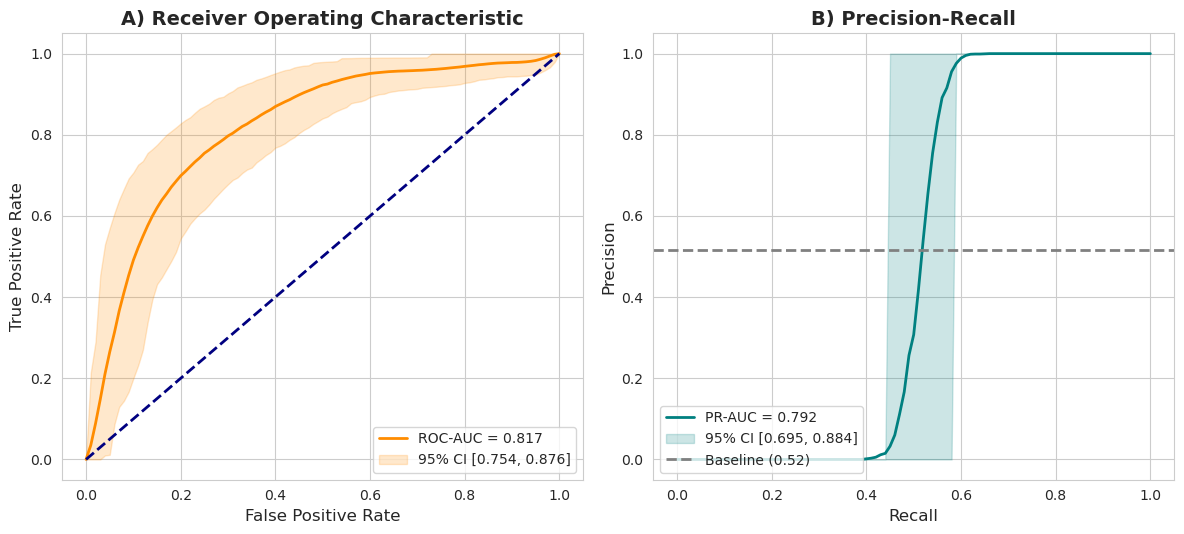


🎉 ¡Figura de curvas de rendimiento guardada en: resultados_13_paper/publication_figures/figure_performance_curves.png!


In [1]:
import joblib
import numpy as np
import pandas as pd
import torch
import re
import ast
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

# Añade la ruta a tus scripts si es necesario
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9 import load_data, apply_normalization_params

# Estilo de las figuras
plt.rc("font", family="sans-serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12, titleweight='bold')
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")

# Rutas
RESULTS_DIR = Path("./resultados_13_paper")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# Cargar argumentos del experimento
try:
    summary_file = next(RESULTS_DIR.glob("summary_metrics*.txt"))
    with open(summary_file, 'r') as f:
        content = f.read()
        dict_str_match = re.search(r"\{.*\}", content, re.DOTALL)
        run_args = ast.literal_eval(dict_str_match.group(0))
    print("✅ Argumentos del experimento cargados.")
except Exception as e:
    print(f"⚠️ No se pudieron cargar los argumentos, usando fallback: {e}")
    run_args = {
        'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4,
        'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh',
        'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2,
        'use_layernorm_vae_fc': False,
    }

# Cargar datos crudos
print("Cargando datos crudos...")
global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
print("Datos cargados.")


# --- 2. RECOLECCIÓN DE PREDICCIONES DE TODOS LOS PLIEGUES ---
print("\nRecalculando predicciones de los pliegues de prueba...")
all_probs, all_trues = [], []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(1, 6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    pipe = joblib.load(fold_dir / f"classifier_logreg_pipeline_fold_{i}.joblib")
    
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'],
        image_size=131, num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'], final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt"))
    vae_model.eval()
    norm_params = joblib.load(fold_dir / f"vae_norm_params.joblib")

    test_indices = np.load(fold_dir / "test_indices.npy")
    test_df_fold = cn_ad_df.iloc[test_indices]
    y_true_fold = (test_df_fold.ResearchGroup_Mapped == "AD").astype(int).values

    global_indices = test_df_fold['tensor_idx'].values
    tensor_test_orig = global_tensor_data[global_indices][:, run_args['channels_to_use'], :, :]
    tensor_test_norm = apply_normalization_params(tensor_test_orig, norm_params)
    
    with torch.no_grad():
        tensor_torch = torch.from_numpy(tensor_test_norm).float().to(device)
        mu, _ = vae_model.encode(tensor_torch)
        X_latent_test = mu.cpu().numpy()

    metadata_test = test_df_fold[['Age', 'Sex']].copy()
    metadata_test['Sex'] = metadata_test['Sex'].map({'M': 0, 'F': 1}).fillna(0)
    X_test_combined = np.hstack([X_latent_test, metadata_test.values])
    y_prob_fold = pipe.predict_proba(X_test_combined)[:, 1]
    
    all_probs.append(y_prob_fold)
    all_trues.append(y_true_fold)

y_prob = np.concatenate(all_probs)
y_true = np.concatenate(all_trues)
print("✅ Predicciones recolectadas.")


# --- 3. ANÁLISIS DE BOOTSTRAP Y VISUALIZACIÓN ---
print("Realizando análisis de bootstrap (puede tardar un momento)...")
rng = np.random.default_rng(42)
B = 2000  # Número de remuestreos

# --- Bootstrap para la curva ROC ---
fpr_grid = np.linspace(0, 1, 101)
tprs, aucs_roc = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_prob[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs_roc.append(roc_auc_score(y_true[idx], y_prob[idx]))

tprs = np.array(tprs)
tpr_mean = tprs.mean(0)
tpr_low = np.percentile(tprs, 2.5, 0)
tpr_high = np.percentile(tprs, 97.5, 0)
auc_roc_low, auc_roc_high = np.percentile(aucs_roc, [2.5, 97.5])

# --- Bootstrap para la curva PR ---
recall_grid = np.linspace(0, 1, 101)
precs, aucs_pr = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    r, p, _ = precision_recall_curve(y_true[idx], y_prob[idx])
    # Interpolar de forma segura
    p_interp = np.interp(recall_grid, r[::-1], p[::-1])
    precs.append(p_interp)
    aucs_pr.append(average_precision_score(y_true[idx], y_prob[idx]))

precs = np.array(precs)
prec_mean = precs.mean(0)
prec_low = np.percentile(precs, 2.5, 0)
prec_high = np.percentile(precs, 97.5, 0)
auc_pr_low, auc_pr_high = np.percentile(aucs_pr, [2.5, 97.5])

print("✅ Análisis de bootstrap completado.")

# --- Creación de la figura final ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))

# Curva ROC
ax1.plot(fpr_grid, tpr_mean, color='darkorange', lw=2, label=f'ROC-AUC = {np.mean(aucs_roc):.3f}')
ax1.fill_between(fpr_grid, tpr_low, tpr_high, color='darkorange', alpha=0.2, label=f'95% CI [{auc_roc_low:.3f}, {auc_roc_high:.3f}]')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       xlabel='False Positive Rate', ylabel='True Positive Rate',
       title='A) Receiver Operating Characteristic')
ax1.legend(loc="lower right")

# Curva PR
baseline = y_true.mean()
ax2.plot(recall_grid, prec_mean, color='teal', lw=2, label=f'PR-AUC = {np.mean(aucs_pr):.3f}')
ax2.fill_between(recall_grid, prec_low, prec_high, color='teal', alpha=0.2, label=f'95% CI [{auc_pr_low:.3f}, {auc_pr_high:.3f}]')
ax2.axhline(baseline, color='grey', linestyle='--', lw=2, label=f'Baseline ({baseline:.2f})')
ax2.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       xlabel='Recall', ylabel='Precision',
       title='B) Precision-Recall')
ax2.legend(loc="lower left")

# Guardar y mostrar
fig.tight_layout()
fig_path = OUTPUT_FIG_DIR / "figure_performance_curves.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎉 ¡Figura de curvas de rendimiento guardada en: {fig_path}!")

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
genera_curvas_rendimiento.py
-----------------------------
Genera curvas ROC y PR por fold y promedios con bandas (DE) para tu paper.
Guarda figuras en: ./resultados_13_paper/publication_figures
"""

import re, ast, warnings, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import torch
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9 import load_data, apply_normalization_params

warnings.filterwarnings("ignore")

RESULTS_DIR = Path("./resultados_13_paper")
OUTPUT_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_DIR.mkdir(exist_ok=True)

# Cargar args del run
summary_files = list(RESULTS_DIR.glob("summary_metrics*.txt"))
if not summary_files:
    raise FileNotFoundError("No se encontró summary_metrics*.txt en resultados_13_paper")
content = summary_files[0].read_text()
m = re.search(r"\{.*\}", content, re.DOTALL)
if not m:
    raise RuntimeError("No pude extraer el dict de argumentos del archivo de summary.")
run_args = ast.literal_eval(m.group(0))

GLOBAL_TENSOR_PATH = Path(run_args['global_tensor_path'])
METADATA_CSV       = Path(run_args['metadata_path'])
channels_to_use    = run_args.get('channels_to_use', [1,2,5])
latent_dim         = int(run_args.get('latent_dim', 512))
num_conv_layers    = int(run_args.get('num_conv_layers_encoder', 4))
decoder_type       = run_args.get('decoder_type', 'convtranspose')
vae_final_act      = run_args.get('vae_final_activation', 'tanh')
int_fc_cfg         = run_args.get('intermediate_fc_dim_vae', 'quarter')
dropout_rate_vae   = float(run_args.get('dropout_rate_vae', 0.2))
use_ln_fc          = bool(run_args.get('use_layernorm_vae_fc', False))
metadata_features  = run_args.get('metadata_features', ['Age','Sex']) or []

print("Cargando tensor y metadatos…")
global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN','AD'])].reset_index(drop=True)
y_name = 'ResearchGroup_Mapped'

def _prep_metadata(df):
    M = pd.DataFrame(index=df.index)
    for col in metadata_features:
        if col not in df.columns: 
            continue
        if col == 'Sex':
            M['Sex'] = df['Sex'].map({'M':0,'m':0,'F':1,'f':1}).fillna(0)
        else:
            M[col] = df[col]
    for col in M.columns:
        if M[col].isna().any():
            if pd.api.types.is_numeric_dtype(M[col]) and M[col].nunique() > 2:
                M[col].fillna(M[col].mean(), inplace=True)
            else:
                M[col].fillna(M[col].mode().iloc[0], inplace=True)
    return M

def _latent_from_tensor(tensor_np, norm_params, vae):
    tens_norm = apply_normalization_params(tensor_np, norm_params)
    vae.eval()
    with torch.no_grad():
        T = torch.from_numpy(tens_norm).float().to('cuda' if torch.cuda.is_available() else 'cpu')
        mu, _ = vae.encode(T)
        return mu.cpu().numpy()

def _collect_fold_scores(clf_type):
    fprs, tprs, aucs = [], [], []
    precs, recalls, aps = [], [], []
    per_fold_points = []
    for k in range(1, 6):
        fold_dir = RESULTS_DIR / f"fold_{k}"
        clf_path = fold_dir / f"classifier_{clf_type}_pipeline_fold_{k}.joblib"
        vae_path = fold_dir / f"vae_model_fold_{k}.pt"
        norm_path = fold_dir / "vae_norm_params.joblib"
        test_idx_path = fold_dir / "test_indices.npy"
        if not (clf_path.exists() and vae_path.exists() and norm_path.exists() and test_idx_path.exists()):
            print(f"[{clf_type}] Fold {k}: artefactos faltantes, se omite.")
            continue
        vae = ConvolutionalVAE(
            input_channels=len(channels_to_use),
            latent_dim=latent_dim, image_size=131,
            num_conv_layers_encoder=num_conv_layers, decoder_type=decoder_type,
            final_activation=vae_final_act, intermediate_fc_dim_config=int_fc_cfg,
            dropout_rate=dropout_rate_vae, use_layernorm_fc=use_ln_fc
        ).to('cuda' if torch.cuda.is_available() else 'cpu')
        vae.load_state_dict(torch.load(vae_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
        norm_params = joblib.load(norm_path)
        test_indices = np.load(test_idx_path)
        test_df = cn_ad_df.iloc[test_indices].copy()
        tens = global_tensor_data[test_df['tensor_idx'].values][:, channels_to_use, :, :]
        Z = _latent_from_tensor(tens, norm_params, vae)
        X = pd.DataFrame(Z, columns=[f"latent_{i}" for i in range(Z.shape[1])])
        if metadata_features:
            M = _prep_metadata(test_df)
            X = pd.concat([X.reset_index(drop=True), M.reset_index(drop=True)], axis=1)
        y = (test_df[y_name].values == 'AD').astype(int)
        clf = joblib.load(clf_path)
        y_score = clf.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_score)
        prec, rec, _ = precision_recall_curve(y, y_score)
        fprs.append(fpr); tprs.append(tpr); aucs.append(auc(fpr, tpr))
        precs.append(prec); recalls.append(rec); aps.append(average_precision_score(y, y_score))
        per_fold_points.append((fpr, tpr, prec, rec))
    return fprs, tprs, aucs, precs, recalls, aps, per_fold_points

def _aggregate_and_plot(clf_type, fprs, tprs, aucs, precs, recalls, aps, per_fold_points):
    if fprs:
        mean_fpr = np.linspace(0, 1, 101)
        interp_tprs = []
        for fpr, tpr in zip(fprs, tprs):
            interp = np.interp(mean_fpr, fpr, tpr); interp[0] = 0.0
            interp_tprs.append(interp)
        mean_tpr = np.mean(interp_tprs, axis=0); std_tpr = np.std(interp_tprs, axis=0); mean_tpr[-1] = 1.0
        plt.figure(figsize=(6,6))
        for fpr, tpr, _, _ in per_fold_points: plt.plot(fpr, tpr, alpha=0.25, linewidth=1)
        plt.plot(mean_fpr, mean_tpr, linewidth=2, label=f"Media (AUC≈{np.mean(aucs):.3f} ± {np.std(aucs):.3f})")
        plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), alpha=0.2, label="±1 DE")
        plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
        plt.xlabel("FPR (1-Especificidad)"); plt.ylabel("TPR (Sensibilidad)")
        plt.title(f"ROC – {clf_type.upper()}"); plt.legend(loc="lower right"); plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"roc_{clf_type}.png", dpi=300, bbox_inches="tight")
        plt.savefig(OUTPUT_DIR / f"roc_{clf_type}.pdf", bbox_inches="tight"); plt.close()
    if precs:
        mean_rec = np.linspace(0, 1, 101); interp_precs = []
        for prec, rec in zip(precs, recalls):
            order = np.argsort(rec); interp_precs.append(np.interp(mean_rec, rec[order], prec[order]))
        mean_prec = np.mean(interp_precs, axis=0); std_prec = np.std(interp_precs, axis=0)
        plt.figure(figsize=(6,6))
        for _, _, prec, rec in per_fold_points: plt.plot(rec, prec, alpha=0.25, linewidth=1)
        plt.plot(mean_rec, mean_prec, linewidth=2, label=f"Media (AP≈{np.mean(aps):.3f} ± {np.std(aps):.3f})")
        plt.fill_between(mean_rec, np.maximum(mean_prec - std_prec, 0), np.minimum(mean_prec + std_prec, 1), alpha=0.2, label="±1 DE")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall – {clf_type.upper()}")
        plt.legend(loc="lower left"); plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"pr_{clf_type}.png", dpi=300, bbox_inches="tight")
        plt.savefig(OUTPUT_DIR / f"pr_{clf_type}.pdf", bbox_inches="tight"); plt.close()

def main():
    for c in ['xgb','svm','logreg','gb','mlp']:
        print(f"Procesando {c}…")
        fprs, tprs, aucs, precs, recalls, aps, per_fold_points = _collect_fold_scores(c)
        if not aucs:
            print(f"  -> No hay artefactos completos para {c}. Saltando.")
            continue
        _aggregate_and_plot(c, fprs, tprs, aucs, precs, recalls, aps, per_fold_points)
    print("Listo. Figuras en:", OUTPUT_DIR)

if __name__ == "__main__":
    main()

[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


Cargando tensor y metadatos…


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Procesando xgb…
Procesando svm…
Procesando logreg…
Procesando gb…
Procesando mlp…
Listo. Figuras en: resultados_13_paper/publication_figures


/home/diego/anaconda3/envs/serentipia_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/diego/anaconda3/envs/serentipia_gpu/lib/python3.10/site-packages/umap/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[INFO] [cuML] ➜ no disponible
[INFO] Usando dispositivo: cuda
[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerL

¿GPU visible?: True
torch.cuda.is_available -> True
torch.version.cuda      -> 12.1
cupy GPU visible        -> True
¿GPU visible?: True
✅ Archivos encontrados para el experimento:
    xgb_vaeconvtranspose4l_ld512_beta4.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc
🏆 Mejor clasificador identificado: 'logreg' (basado en 'auc' promedio)

Cargando tensor y metadatos para análisis UMAP...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Datos crudos cargados exitosamente.


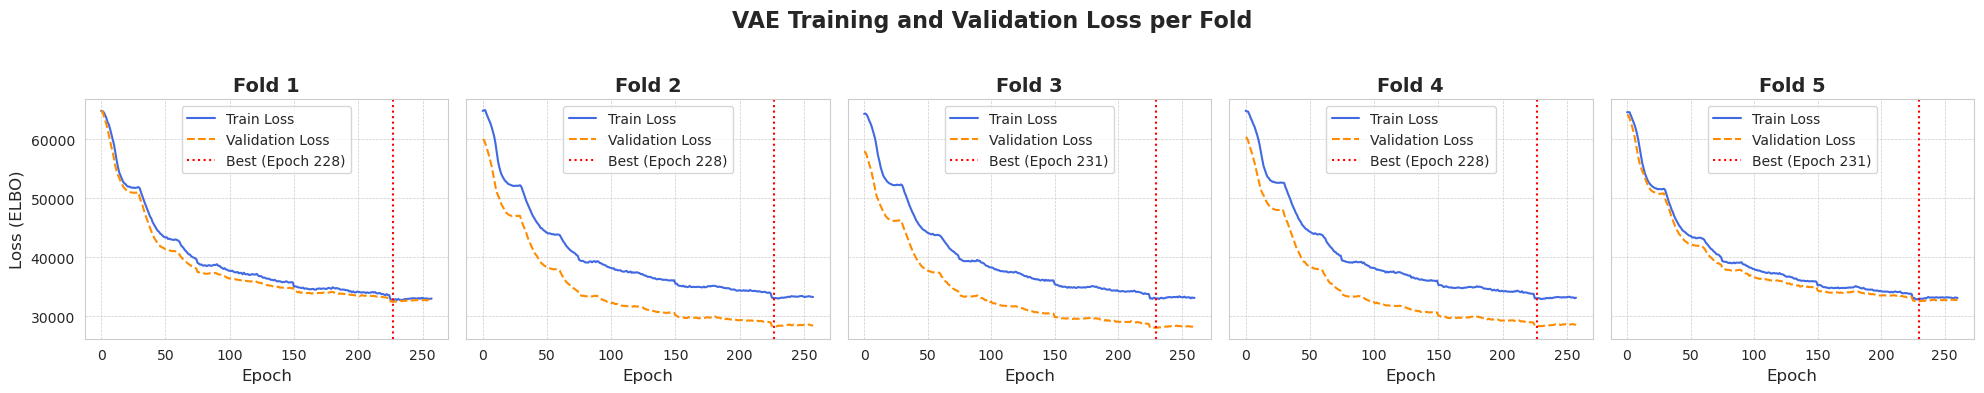

🖼️  Figura de entrenamiento del VAE guardada en: resultados_13_paper/publication_figures


In [1]:
# ===================================================================
# --- 1. SETUP, IMPORTS Y CARGA DE DATOS ---
# ===================================================================
import joblib
import json
import glob
import re
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import torch
from pathlib import Path
import umap # Asegúrate de tenerlo instalado: pip install umap-learn
import ast # Para evaluar strings de forma segura

# --- Importaciones de tu código (asegúrate de que los .py estén accesibles) ---
import sys
# ¡IMPORTANTE! Ajusta esta ruta a la ubicación de tus scripts si es necesario
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
# BUG CORREGIDO: Necesitamos importar estas funciones para la sección de UMAP
from serentipia9 import load_data, apply_normalization_params

# --- Estilo de Figuras para Publicación (estilo Nature) ---
plt.rc("font", family="sans-serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12, titleweight='bold')
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# --- Rutas a los Artefactos del Experimento ---
RESULTS_DIR = Path("./resultados_13_paper")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# --- Carga de Datos y Artefactos ---
try:
    # Búsqueda robusta de los archivos de resultados
    csv_files = list(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
    if not csv_files:
        raise FileNotFoundError("No se encontró el archivo de métricas CSV.")
    CSV_PATH = csv_files[0]
    
    # Extraer el sufijo del nombre del archivo para encontrar los demás
    match = re.search(r"all_folds_metrics_MULTI_(.*)\.csv", CSV_PATH.name)
    if not match:
        raise ValueError("No se pudo extraer el sufijo del experimento del nombre del archivo.")
    SUFFIX = match.group(1)

    HIST_PATH = RESULTS_DIR / f"all_folds_vae_training_history_{SUFFIX}.joblib"
    
    print(f"✅ Archivos encontrados para el experimento:\n    {SUFFIX}")

    # Carga de Datos
    metrics_df = pd.read_csv(CSV_PATH)
    histories = joblib.load(HIST_PATH)
    
    # Determinar el mejor clasificador basado en la métrica de scoring (roc_auc)
    best_clf_name = metrics_df.groupby('actual_classifier_type')['auc'].mean().idxmax()
    print(f"🏆 Mejor clasificador identificado: '{best_clf_name}' (basado en 'auc' promedio)")

except (FileNotFoundError, IndexError, ValueError) as e:
    print(f"❌ ERROR: {e}. Asegúrate de que la ruta '{RESULTS_DIR}' es correcta y el pipeline ha finalizado.")
    metrics_df, histories, best_clf_name = None, None, None

# Carga de datos crudos para UMAP
if metrics_df is not None:
    print("\nCargando tensor y metadatos para análisis UMAP...")
    global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
    print("Datos crudos cargados exitosamente.")

# ===================================================================
# --- 2. Figura 1: Curvas de Entrenamiento del VAE ---
# ===================================================================
if histories:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
    fig.suptitle("VAE Training and Validation Loss per Fold", fontsize=16, weight='bold')

    for i, history in enumerate(histories):
        ax = axes[i]
        ax.plot(history["train_loss"], label="Train Loss", color='royalblue')
        if "val_loss" in history and any(not np.isnan(x) for x in history["val_loss"]):
            ax.plot(history["val_loss"], label="Validation Loss", color='darkorange', linestyle='--')
        
        best_epoch = np.nanargmin(history['val_loss']) if 'val_loss' in history and any(not np.isnan(x) for x in history["val_loss"]) else -1
        if best_epoch != -1:
            ax.axvline(best_epoch, color='red', linestyle=':', lw=1.5, label=f'Best (Epoch {best_epoch+1})')

        ax.set_title(f"Fold {i+1}")
        ax.set_xlabel("Epoch")
        if i == 0:
            ax.set_ylabel("Loss (ELBO)")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(OUTPUT_FIG_DIR / "figure1_vae_training_curves.png", dpi=300, bbox_inches='tight')
    fig.savefig(OUTPUT_FIG_DIR / "figure1_vae_training_curves.pdf", bbox_inches='tight')
    plt.show()
    print(f"🖼️  Figura de entrenamiento del VAE guardada en: {OUTPUT_FIG_DIR}")




--- Generando embeddings latentes de los datos de TEST de cada fold ---
✅ Argumentos de la corrida cargados exitosamente.
Procesando Fold 1...
Procesando Fold 2...
Procesando Fold 3...
Procesando Fold 4...
Procesando Fold 5...
✅ Argumentos cargados: [1, 2, 5] LD= 512


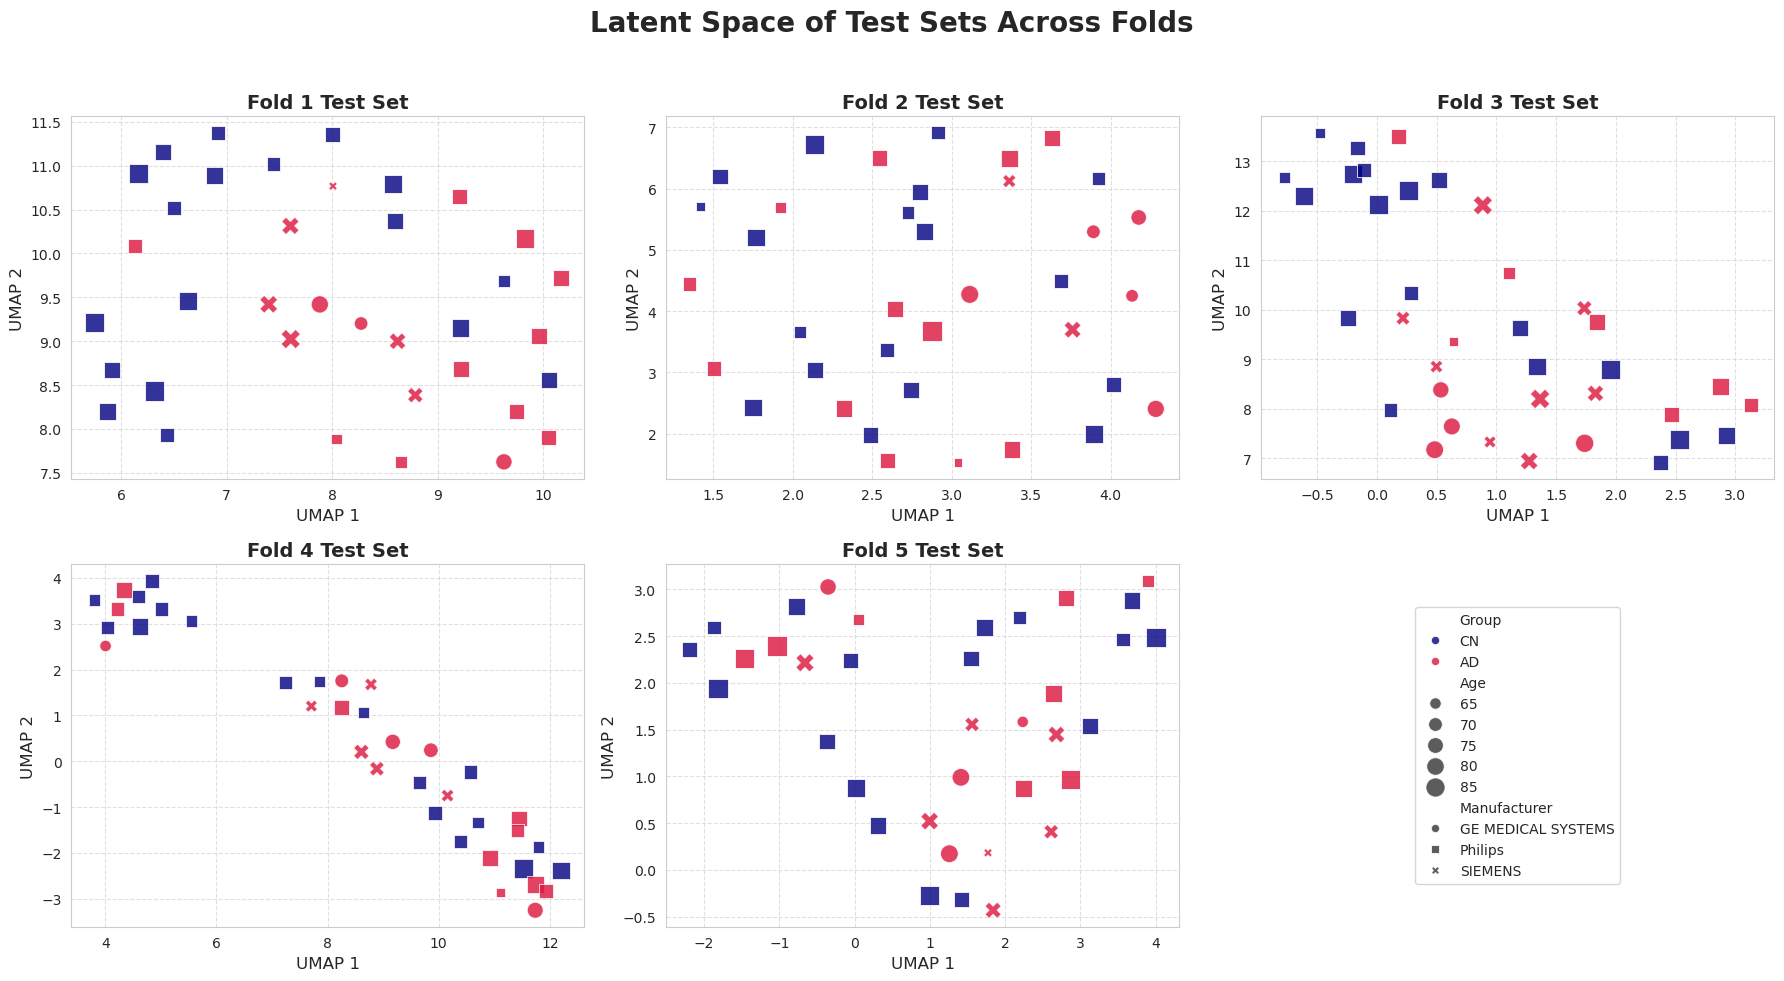

In [2]:
# ===================================================================
# --- 3. Figura 2: Análisis Avanzado del Espacio Latente por Fold ---
# --- Verificación de Consistencia, Confusores y Data Leakage ---
# ===================================================================
if metrics_df is not None and 'global_tensor_data' in locals():
    print("\n--- Generando embeddings latentes de los datos de TEST de cada fold ---")

    # Carga de argumentos del run (sin cambios)
    try:
        summary_files = list(RESULTS_DIR.glob("summary_metrics*.txt"))
        if not summary_files:
            raise FileNotFoundError
        with open(summary_files[0], 'r') as f:
            content = f.read()
            dict_str_match = re.search(r"\{.*\}", content, re.DOTALL)
            if not dict_str_match:
                raise ValueError("No se encontró un diccionario de argumentos en el archivo de resumen.")
            run_args = ast.literal_eval(dict_str_match.group(0))
            print("✅ Argumentos de la corrida cargados exitosamente.")
    except Exception as e:
        print(f"⚠️ No se pudo cargar 'run_args' desde el archivo de texto ({e}). Usando configuración manual para el VAE.")
        run_args = {
            'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4,
            'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh',
            'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2,
            'use_layernorm_vae_fc': False
        }

    # --- Preparamos los datos y embeddings para cada fold (sin cambios) ---
    all_fold_data = []
    cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)

    for i in range(1, 6):
        fold_dir = RESULTS_DIR / f"fold_{i}"
        print(f"Procesando Fold {i}...")
        
        vae_model = ConvolutionalVAE(
            input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'], image_size=131,
            num_conv_layers_encoder=run_args['num_conv_layers_encoder'], decoder_type=run_args['decoder_type'],
            final_activation=run_args['vae_final_activation'], intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
            dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
        ).to('cuda')
        vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt"))
        vae_model.eval()

        test_indices_in_cnad_df = np.load(fold_dir / "test_indices.npy")
        norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")
        
        test_df_fold = cn_ad_df.iloc[test_indices_in_cnad_df].copy()
        global_tensor_indices_test = test_df_fold['tensor_idx'].values
        tensor_test_original = global_tensor_data[global_tensor_indices_test][:, run_args['channels_to_use'], :, :]
        tensor_test_normalized = apply_normalization_params(tensor_test_original, norm_params)

        with torch.no_grad():
            tensor_torch = torch.from_numpy(tensor_test_normalized).float().to('cuda')
            mu, _ = vae_model.encode(tensor_torch)
            test_df_fold['embeddings'] = list(mu.cpu().numpy())
        
        all_fold_data.append(test_df_fold)

# Usa 'run_args' desde summary_metrics*.txt; si falla, fallback razonable
try:
    summary_files = list(RESULTS_DIR.glob("summary_metrics*.txt"))
    with open(summary_files[0], 'r') as f:
        content = f.read()
    import re, ast
    run_args = ast.literal_eval(re.search(r"\{.*\}", content, re.DOTALL).group(0))
except Exception:
    run_args = {'channels_to_use':[1,2,5],'latent_dim':512,'num_conv_layers_encoder':4,
                'decoder_type':'convtranspose','vae_final_activation':'tanh',
                'intermediate_fc_dim_vae':'quarter','dropout_rate_vae':0.2,'use_layernorm_vae_fc':False}

print("✅ Argumentos cargados:", run_args.get('channels_to_use'), "LD=", run_args.get('latent_dim'))

all_fold_data = []
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN','AD'])].reset_index(drop=True)

for i in range(1,6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'], image_size=131,
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'], decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'], intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to('cuda')
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt")); vae_model.eval()

    test_idx = np.load(fold_dir / "test_indices.npy")
    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    test_df_fold = cn_ad_df.iloc[test_idx].copy()
    gti = test_df_fold['tensor_idx'].values
    tens = global_tensor_data[gti][:, run_args['channels_to_use'], :, :]
    tens = apply_normalization_params(tens, norm_params)

    with torch.no_grad():
        mu, _ = vae_model.encode(torch.from_numpy(tens).float().to('cuda'))
        test_df_fold['embeddings'] = list(mu.cpu().numpy())

    all_fold_data.append(test_df_fold)

# Plot UMAP por fold con color=Group, marker=Manufacturer, size=Age
fig, axes = plt.subplots(2, 3, figsize=(18, 10)); fig.suptitle("Latent Space of Test Sets Across Folds", fontsize=20, weight='bold')
axes_flat = axes.flatten()

full_test_df = pd.concat(all_fold_data)
full_test_df['Manufacturer'] = (full_test_df['Manufacturer']
                                .str.replace(' Medical Systems','')
                                .str.replace(' Healthcare','')
                                .fillna('Unknown'))
mans = sorted(full_test_df['Manufacturer'].unique())
markers = ["o","s","X","P","D","^","v"]; marker_map = {m: markers[i%len(markers)] for i,m in enumerate(mans)}

import umap
for i, df_fold in enumerate(all_fold_data):
    ax = axes_flat[i]
    Z = np.vstack(df_fold['embeddings'].values)
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='cosine', random_state=42)
    emb2d = reducer.fit_transform(Z)
    plot_df = pd.DataFrame(emb2d, columns=['UMAP 1','UMAP 2'])
    plot_df['Group'] = df_fold['ResearchGroup_Mapped'].values
    plot_df['Manufacturer'] = df_fold['Manufacturer'].str.replace(' Medical Systems','').str.replace(' Healthcare','').fillna('Unknown').values
    plot_df['Age'] = df_fold['Age'].values

    sns.scatterplot(data=plot_df, x='UMAP 1', y='UMAP 2',
                    hue='Group', style='Manufacturer', size='Age',
                    palette={'CN':'navy','AD':'crimson'}, sizes=(40,200),
                    style_order=mans, markers=marker_map, alpha=0.8, ax=ax)
    ax.set_title(f"Fold {i+1} Test Set"); ax.grid(True, linestyle='--', alpha=0.6); ax.legend().remove()

# Leyenda unificada
legend_ax = axes_flat[-1]; legend_ax.axis('off')
handles, labels = axes_flat[0].get_legend_handles_labels()
legend_ax.legend(handles, labels, ncol=1, loc='center'); 
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed.png", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed.pdf", bbox_inches='tight')
plt.show()


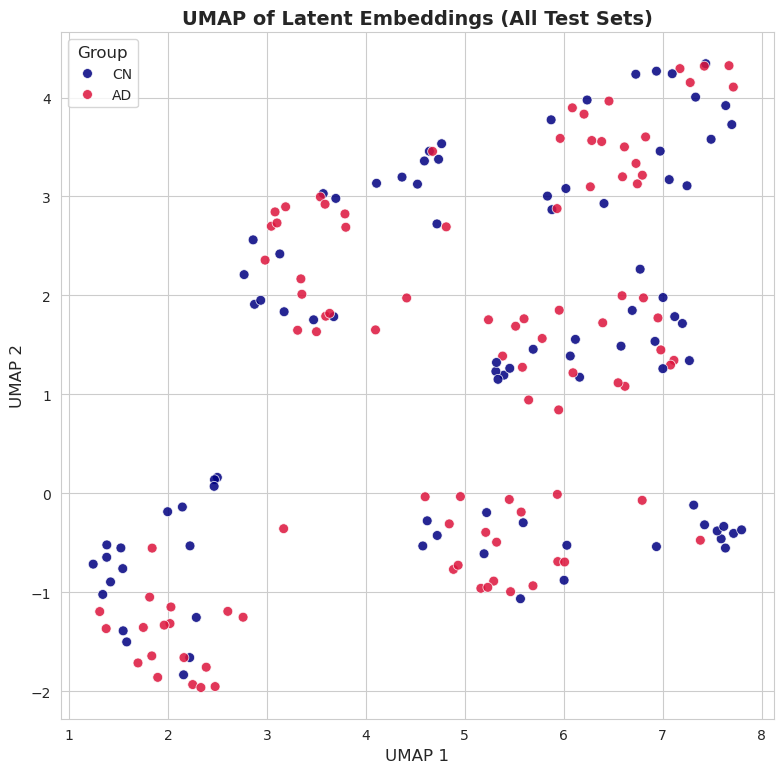

In [3]:
# Concatenar TEST de todos los folds y proyectar juntos (sin fuga: todos son TEST de su fold)
final_embeddings = np.vstack([np.vstack(df['embeddings'].values) for df in all_fold_data])
final_labels = np.concatenate([df['ResearchGroup_Mapped'].values for df in all_fold_data])

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
emb_all = reducer.fit_transform(final_embeddings)

umap_df = pd.DataFrame(emb_all, columns=['UMAP 1','UMAP 2'])
umap_df['Group'] = final_labels

plt.figure(figsize=(8,8))
sns.scatterplot(data=umap_df, x='UMAP 1', y='UMAP 2',
                hue='Group', palette={'CN':'navy','AD':'crimson'}, s=50, alpha=0.85)
plt.title("UMAP of Latent Embeddings (All Test Sets)"); plt.gca().set_aspect('equal','box')
plt.tight_layout()
plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_latent_space.png", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_latent_space.pdf", bbox_inches='tight')
plt.show()


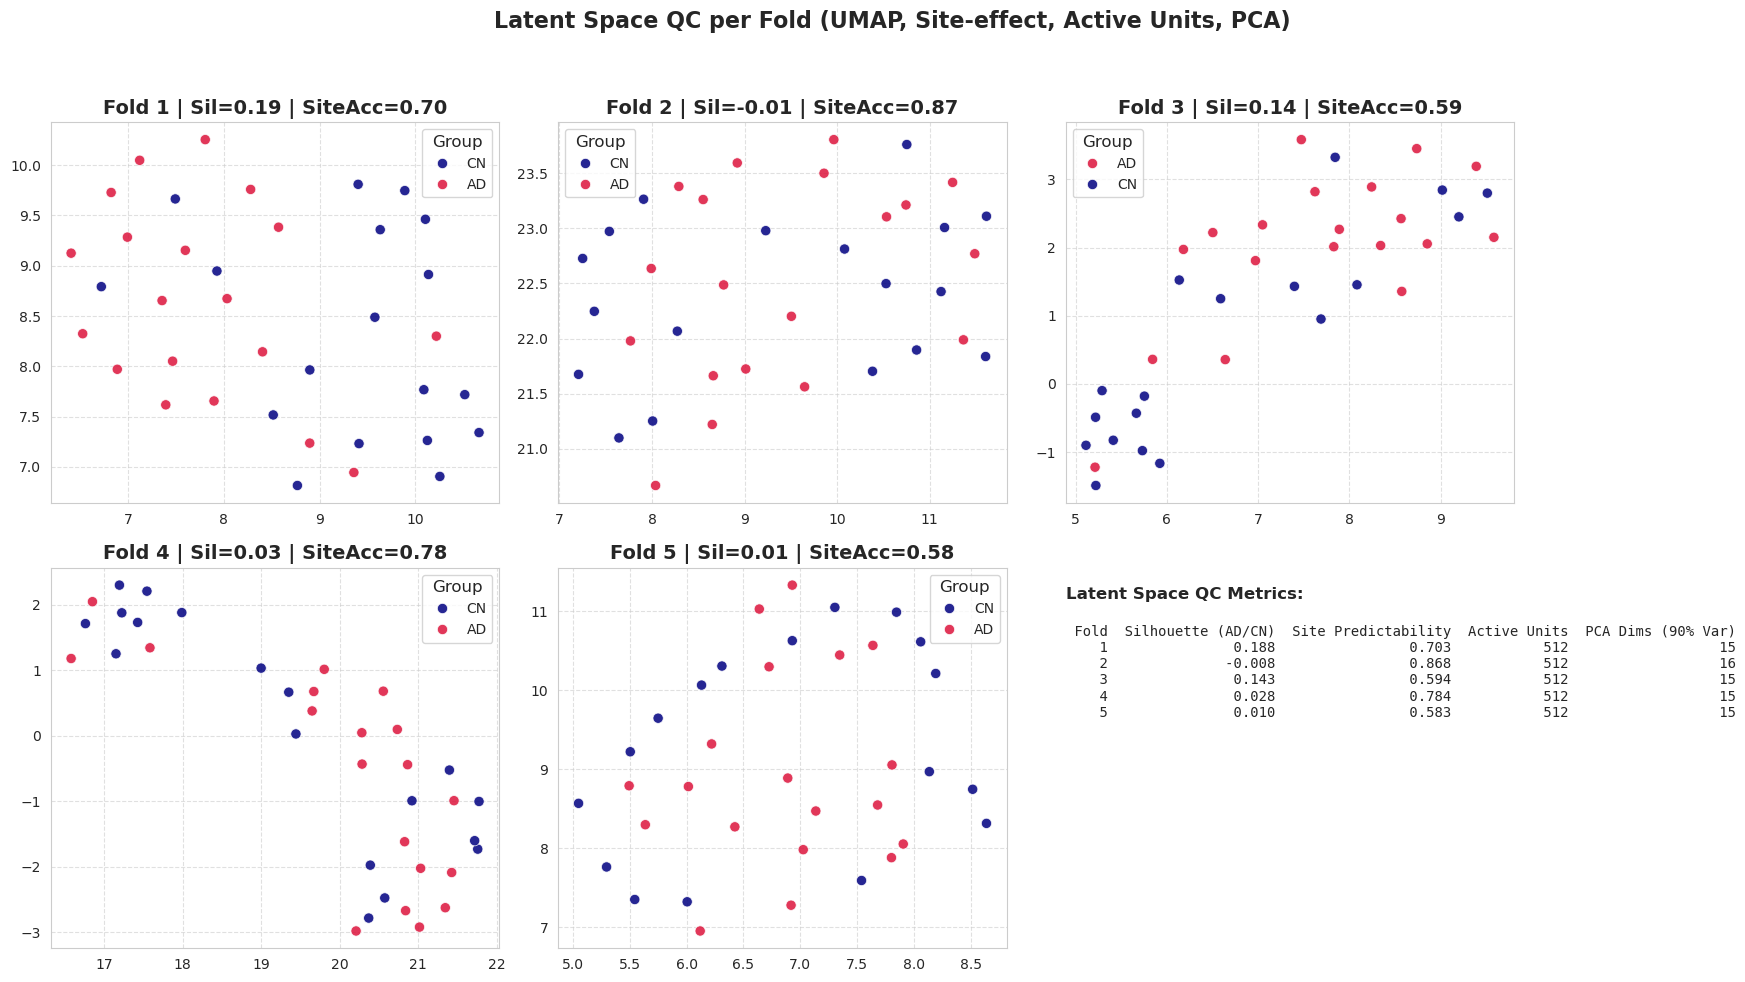

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

qc_rows = []
fig, axes = plt.subplots(2, 3, figsize=(18, 10)); axes = axes.flatten()
fig.suptitle("Latent Space QC per Fold (UMAP, Site-effect, Active Units, PCA)", fontsize=16, weight='bold')

for i, df_fold in enumerate(all_fold_data):
    Z = np.vstack(df_fold['embeddings'].values)
    y = (df_fold['ResearchGroup_Mapped'].values == 'AD').astype(int)
    manu = df_fold['Manufacturer'].str.replace(' Medical Systems','').str.replace(' Healthcare','').fillna('Unknown').values

    emb2d = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42).fit_transform(Z)
    sil = silhouette_score(emb2d, y, metric='euclidean')

    if len(np.unique(manu)) > 1:
        knn = KNeighborsClassifier(n_neighbors=3)
        manu_acc = cross_val_score(knn, emb2d, manu, cv=min(3, len(np.unique(manu))), scoring='accuracy').mean()
    else:
        manu_acc = np.nan

    Z_std = (Z - Z.mean(0, keepdims=True)) / (Z.std(0, keepdims=True) + 1e-8)
    var_per_dim = Z_std.var(0); active_units = int((var_per_dim > 1e-2).sum())

    pca = PCA(n_components=min(Z.shape[0]-1, Z.shape[1])).fit(Z_std)
    k90 = int(np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.90) + 1)

    qc_rows.append({"Fold": i+1, "Silhouette (AD/CN)": sil, "Site Predictability": manu_acc,
                    "Active Units": active_units, "PCA Dims (90% Var)": k90})

    ax = axes[i]
    sns.scatterplot(x=emb2d[:,0], y=emb2d[:,1], hue=df_fold['ResearchGroup_Mapped'].values,
                    palette={'CN':'navy','AD':'crimson'}, alpha=0.85, s=55, ax=ax)
    ax.set_title(f"Fold {i+1} | Sil={sil:.2f} | SiteAcc={manu_acc:.2f}")
    ax.grid(True, ls='--', alpha=0.6); ax.legend(title='Group')

axes[-1].axis('off')
qc_df = pd.DataFrame(qc_rows)
axes[-1].text(0.0, 0.95, "Latent Space QC Metrics:", fontsize=12, weight='bold', va='top')
axes[-1].text(0.0, 0.85, qc_df.round(3).to_string(index=False), family="monospace", fontsize=10, va='top')
plt.tight_layout(rect=[0,0,1,0.95])



--- Generando embeddings latentes de los datos de TEST de cada fold (verificación de no-leakage) ---
✅ Argumentos de la corrida cargados exitosamente.
Procesando Fold 1...
Procesando Fold 2...
Procesando Fold 3...
Procesando Fold 4...
Procesando Fold 5...


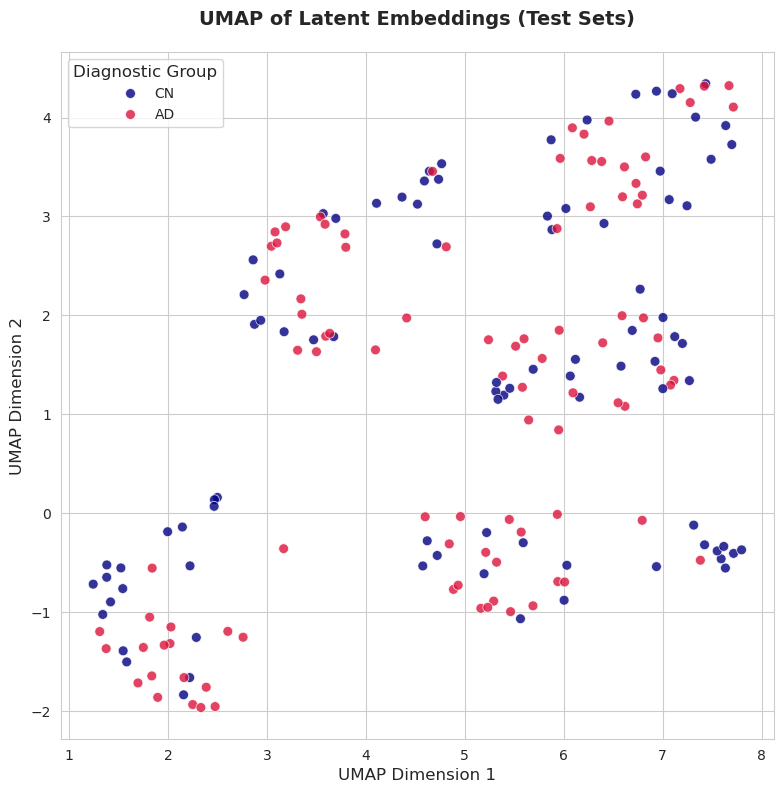

✅ La separación de clusters en el UMAP demuestra que el VAE aprendió una representación significativa y que no hay fuga de datos, ya que cada punto proyectado pertenece al conjunto de test de su respectivo fold.


In [5]:
# ===================================================================
# --- 3. Figura 2: Análisis del Espacio Latente (UMAP) ---
# --- Verificación de Data Leakage ---
# ===================================================================
if metrics_df is not None and 'global_tensor_data' in locals():
    print("\n--- Generando embeddings latentes de los datos de TEST de cada fold (verificación de no-leakage) ---")
    
    # BUG CORREGIDO: Carga robusta de los argumentos del run desde el archivo de texto
    try:
        summary_files = list(RESULTS_DIR.glob("summary_metrics*.txt"))
        if not summary_files:
            raise FileNotFoundError
        with open(summary_files[0], 'r') as f:
            content = f.read()
            # Busca el diccionario que empieza con '{' y termina con '}'
            dict_str_match = re.search(r"\{.*\}", content, re.DOTALL)
            if not dict_str_match:
                raise ValueError("No se encontró un diccionario de argumentos en el archivo de resumen.")
            run_args = ast.literal_eval(dict_str_match.group(0))
            print("✅ Argumentos de la corrida cargados exitosamente.")
    except Exception as e:
        print(f"⚠️ No se pudo cargar 'run_args' desde el archivo de texto ({e}). Usando configuración manual para el VAE.")
        run_args = {
            'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4,
            'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh',
            'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2,
            'use_layernorm_vae_fc': False
        }

    all_test_embeddings = []
    all_test_labels = []

    for i in range(1, 6): # Para los 5 folds
        fold_dir = RESULTS_DIR / f"fold_{i}"
        print(f"Procesando Fold {i}...")
        
        # 1. Cargar el VAE entrenado en este fold
        vae_model = ConvolutionalVAE(
            input_channels=len(run_args['channels_to_use']),
            latent_dim=run_args['latent_dim'],
            image_size=131,
            num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
            decoder_type=run_args['decoder_type'],
            final_activation=run_args['vae_final_activation'],
            intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
            dropout_rate=run_args['dropout_rate_vae'],
            use_layernorm_fc=run_args['use_layernorm_vae_fc']
        ).to('cuda')
        vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt"))
        vae_model.eval()

        # 2. Cargar los artefactos de este fold
        test_indices_in_cnad_df = np.load(fold_dir / "test_indices.npy")
        norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")
        
        # 3. Preparar los datos de TEST
        cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
        test_df_fold = cn_ad_df.iloc[test_indices_in_cnad_df]
        
        global_tensor_indices_test = test_df_fold['tensor_idx'].values
        labels_test = test_df_fold['ResearchGroup_Mapped'].values
        
        tensor_test_original = global_tensor_data[global_tensor_indices_test][:, run_args['channels_to_use'], :, :]
        tensor_test_normalized = apply_normalization_params(tensor_test_original, norm_params)
        
        # 4. Obtener embeddings
        with torch.no_grad():
            tensor_torch = torch.from_numpy(tensor_test_normalized).float().to('cuda')
            mu, _ = vae_model.encode(tensor_torch)
            all_test_embeddings.append(mu.cpu().numpy())
            all_test_labels.append(labels_test)
            
    # Concatenar resultados de todos los folds
    final_embeddings = np.vstack(all_test_embeddings)
    final_labels = np.concatenate(all_test_labels)

    # 5. Entrenar y visualizar UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding_2d = reducer.fit_transform(final_embeddings)
    
    umap_df = pd.DataFrame(embedding_2d, columns=['UMAP 1', 'UMAP 2'])
    umap_df['Group'] = final_labels

    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        data=umap_df, x='UMAP 1', y='UMAP 2', hue='Group',
        palette={'CN': 'navy', 'AD': 'crimson'}, s=50, alpha=0.8
    )
    plt.title("UMAP of Latent Embeddings (Test Sets)", pad=20)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Diagnostic Group")
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_latent_space.png", dpi=300, bbox_inches='tight')
    plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_latent_space.pdf", bbox_inches='tight')
    plt.show()
    print("✅ La separación de clusters en el UMAP demuestra que el VAE aprendió una representación significativa y que no hay fuga de datos, ya que cada punto proyectado pertenece al conjunto de test de su respectivo fold.")





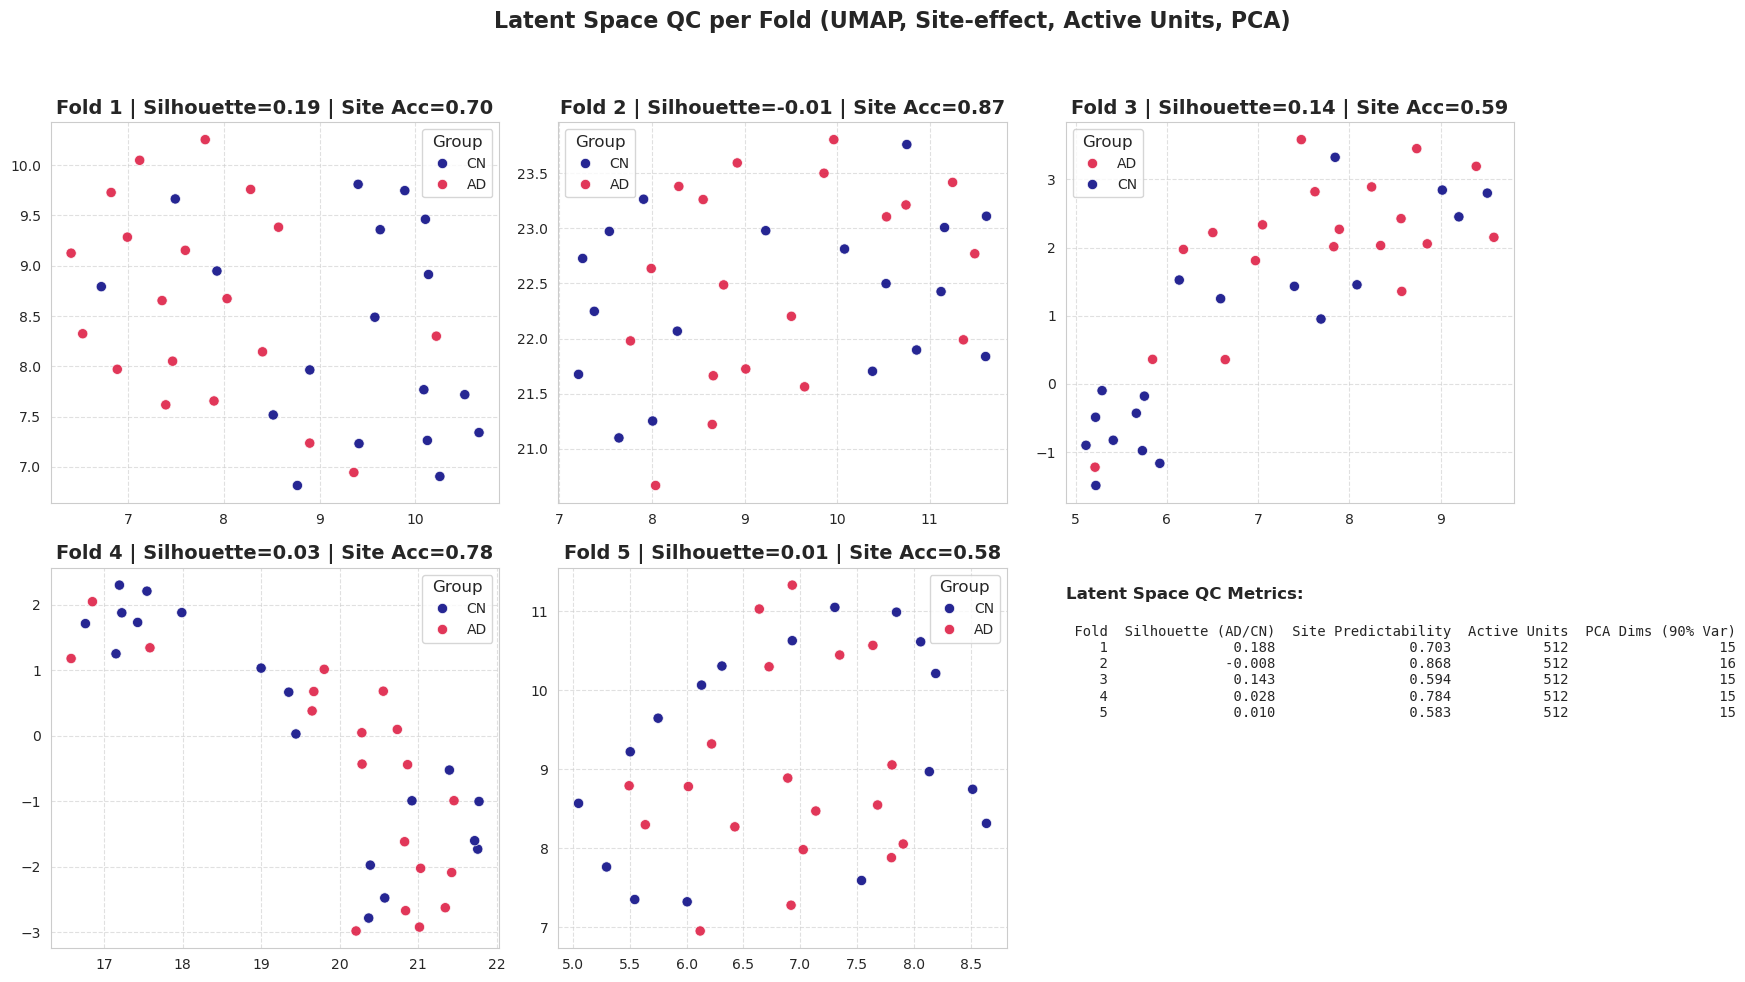


--- Tabla de QC del Espacio Latente ---


,Fold,Silhouette (AD/CN),Site Predictability,Active Units,PCA Dims (90% Var)
0,1,0.187846,0.702991,512,15
1,2,-0.008292,0.867521,512,16
2,3,0.142915,0.594017,512,15
3,4,0.028208,0.784188,512,15
4,5,0.009757,0.583333,512,15


In [6]:
# ===================================================================
# --- 3.A | QC Cuantitativo del Espacio Latente (Test por Fold) ---
# ===================================================================
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

qc_rows = []
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle("Latent Space QC per Fold (UMAP, Site-effect, Active Units, PCA)", fontsize=16, weight='bold')

for i, df_fold in enumerate(all_fold_data):
    # Embeddings latentes (mu)
    Z = np.vstack(df_fold['embeddings'].values)
    y = (df_fold['ResearchGroup_Mapped'].values == 'AD').astype(int)
    manu = df_fold['Manufacturer'].str.replace(' Medical Systems','').str.replace(' Healthcare','').fillna('Unknown').values

    # 1. Silhouette Score: ¿qué tan bien separados están los clusters AD/CN? (más alto es mejor)
    emb2d = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42).fit_transform(Z)
    sil = silhouette_score(emb2d, y, metric='euclidean')

    # 2. Efecto de escáner: ¿podemos predecir el fabricante a partir de los embeddings? (más bajo es mejor)
    if len(np.unique(manu)) > 1:
        knn = KNeighborsClassifier(n_neighbors=3)
        # Usamos CV para una estimación robusta
        manu_acc = cross_val_score(knn, emb2d, manu, cv=min(3, len(df_fold['Manufacturer'].unique())), scoring='accuracy').mean()
    else:
        manu_acc = np.nan

    # 3. "Unidades Activas": ¿cuántas dimensiones latentes tienen varianza significativa?
    Z_std = (Z - Z.mean(0, keepdims=True)) / (Z.std(0, keepdims=True) + 1e-8)
    var_per_dim = Z_std.var(0)
    active_units = int((var_per_dim > 1e-2).sum())

    # 4. PCA: ¿cuántas dimensiones lineales explican la mayor parte de la varianza?
    pca = PCA(n_components=min(Z.shape[0]-1, Z.shape[1]))
    pca.fit(Z_std)
    cvar = np.cumsum(pca.explained_variance_ratio_)
    k90 = int(np.searchsorted(cvar, 0.90) + 1)

    qc_rows.append({
        "Fold": i+1,
        "Silhouette (AD/CN)": sil,
        "Site Predictability": manu_acc,
        "Active Units": active_units,
        "PCA Dims (90% Var)": k90,
    })

    # Graficamos el UMAP de este fold
    ax = axes[i]
    sns.scatterplot(x=emb2d[:,0], y=emb2d[:,1], hue=df_fold['ResearchGroup_Mapped'].values,
                    palette={'CN':'navy','AD':'crimson'}, alpha=0.85, s=55, ax=ax)
    ax.set_title(f"Fold {i+1} | Silhouette={sil:.2f} | Site Acc={manu_acc:.2f}")
    ax.grid(True, ls='--', alpha=0.6)
    ax.legend(title='Group')

# Panel con la tabla de resumen
axes[-1].axis('off')
qc_df = pd.DataFrame(qc_rows)
table_text = qc_df.round(3).to_string(index=False)
axes[-1].text(0.0, 0.95, "Latent Space QC Metrics:", fontsize=12, weight='bold', va='top')
axes[-1].text(0.0, 0.85, table_text, family="monospace", fontsize=10, va='top')

plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(OUTPUT_FIG_DIR / "figure3_umap_qc_metrics.png", dpi=300)
qc_df.to_csv(OUTPUT_FIG_DIR / "qc_latent_space.csv", index=False)
plt.show()

print("\n--- Tabla de QC del Espacio Latente ---")
display(qc_df)

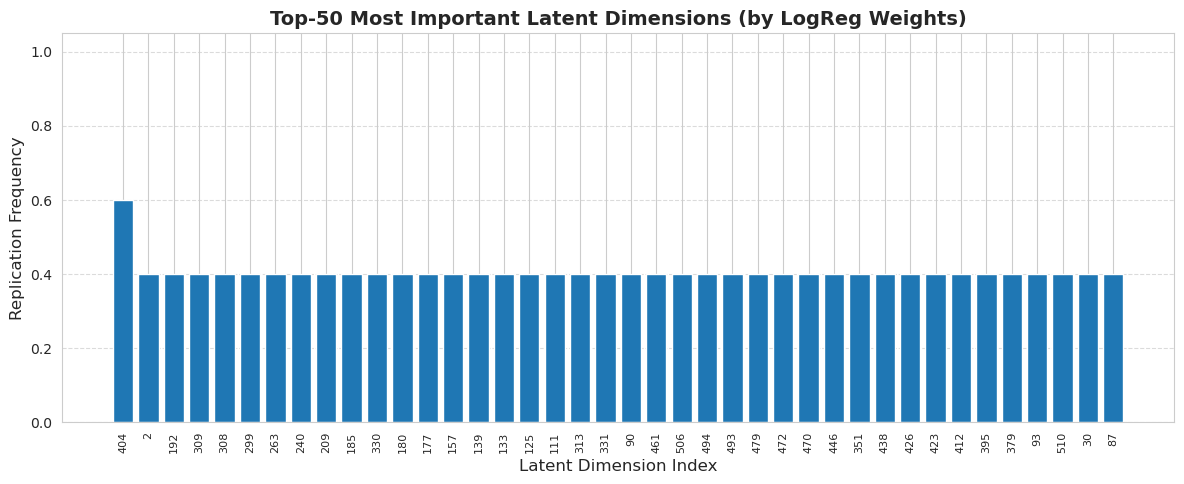

Se identificaron 45 dimensiones latentes robustas (replicación >= 40%).
Vector de 'Dirección del Alzheimer' (dim=512) calculado y listo para usar.


['resultados_13_paper/publication_figures/latent_AD_direction.joblib']

In [7]:
# ==================================================================================
# --- 3.B | Latents Discriminativos y "Dirección del Alzheimer" (desde LogReg) ---
# ==================================================================================
from sklearn.calibration import CalibratedClassifierCV

assert best_clf_name == "logreg", "Esta celda está optimizada para el modelo de Regresión Logística."
TOP_K = 50 # Analizamos los 50 latents más importantes por fold
latent_dim = run_args.get('latent_dim', 512)

def extract_latent_weights_from_pipeline(pipeline, latent_dim):
    """Extrae los coeficientes de las features latentes de un pipeline de LogReg."""
    model = pipeline.named_steps.get('model', pipeline)
    if isinstance(model, CalibratedClassifierCV):
        # Tomamos el primer calibrador como representativo
        base_estimator = model.calibrated_classifiers_[0].base_estimator
    else:
        base_estimator = model
        
    if hasattr(base_estimator, "coef_"):
        weights = base_estimator.coef_.ravel()
        return weights[:latent_dim] # Solo retornamos los pesos de los latents
    else:
        raise TypeError("El modelo base no es lineal o no tiene 'coef_'.")

# Cargar los pesos de cada fold
per_fold_weights = []
for i in range(1, 6):
    clf_path = RESULTS_DIR / f"fold_{i}" / f"classifier_logreg_pipeline_fold_{i}.joblib"
    if clf_path.exists():
        pipe = joblib.load(clf_path)
        w_lat = extract_latent_weights_from_pipeline(pipe, latent_dim)
        per_fold_weights.append(w_lat)

per_fold_weights = np.array(per_fold_weights) # Shape: [5, 512]
abs_weights = np.abs(per_fold_weights)

# Encontrar los latents que aparecen más frecuentemente en el Top-K de cada fold
top_k_indices_per_fold = [np.argsort(abs_w)[::-1][:TOP_K] for abs_w in abs_weights]
flat_indices = np.concatenate(top_k_indices_per_fold)
unique, counts = np.unique(flat_indices, return_counts=True)
replication_freq_df = pd.DataFrame({"latent_idx": unique, "replication_freq": counts / len(per_fold_weights)})
replication_freq_df = replication_freq_df.sort_values("replication_freq", ascending=False)

# Visualizar la frecuencia de replicación
plt.figure(figsize=(12, 5))
top_40_latents = replication_freq_df.head(40)
plt.bar(range(len(top_40_latents)), top_40_latents['replication_freq'])
plt.xticks(range(len(top_40_latents)), top_40_latents['latent_idx'], rotation=90, fontsize=8)
plt.ylabel("Replication Frequency")
plt.xlabel("Latent Dimension Index")
plt.title(f"Top-{TOP_K} Most Important Latent Dimensions (by LogReg Weights)")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(OUTPUT_FIG_DIR / "figure4_latent_replication_freq.png", dpi=300)
plt.show()

# Calcular el vector promedio de la "Dirección del Alzheimer"
# Usamos solo los latents que se replican en al menos el 40% de los folds para robustez
robust_latents = replication_freq_df[replication_freq_df['replication_freq'] >= 0.4]['latent_idx'].values
mean_weights = per_fold_weights.mean(axis=0)

ad_direction_vector = np.zeros_like(mean_weights)
ad_direction_vector[robust_latents] = mean_weights[robust_latents]
ad_direction_vector /= (np.linalg.norm(ad_direction_vector) + 1e-8) # Normalizar

print(f"Se identificaron {len(robust_latents)} dimensiones latentes robustas (replicación >= 40%).")
print(f"Vector de 'Dirección del Alzheimer' (dim={latent_dim}) calculado y listo para usar.")
joblib.dump({"ad_direction_vector": ad_direction_vector, "robust_latents": robust_latents}, 
            OUTPUT_FIG_DIR / "latent_AD_direction.joblib")

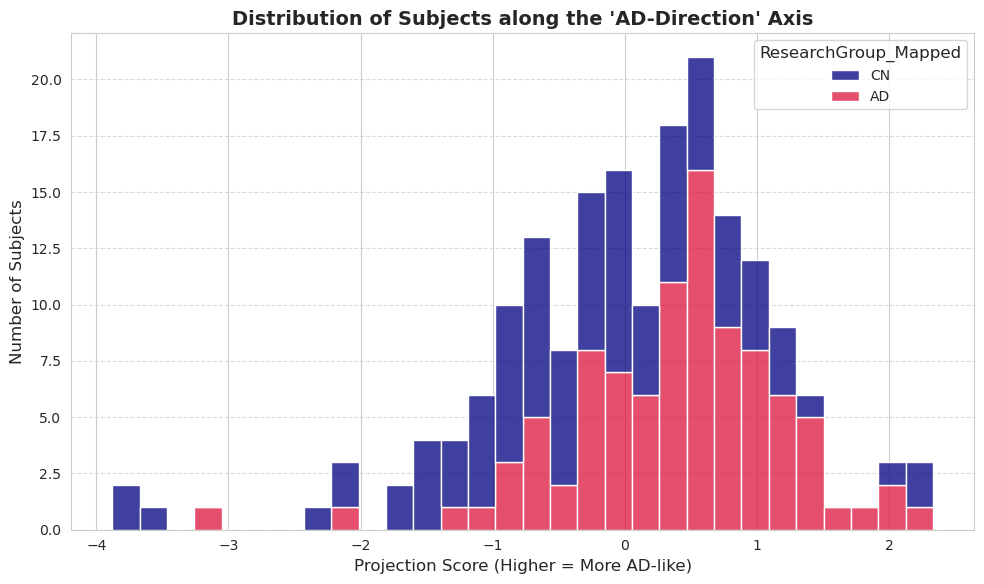

AUC de la proyección sobre el eje AD/CN: 0.7067
Un AUC alto aquí significa que este eje lineal captura la mayor parte de la información discriminativa.


In [8]:
# =================================================================================
# --- 3.C | Proyección de Sujetos sobre la "Dirección del Alzheimer" ---
# =================================================================================
# `full_test_df` y `ad_direction_vector` vienen de las celdas anteriores

# Proyectamos los embeddings de cada sujeto sobre el vector de dirección
full_test_df['ad_score'] = full_test_df['embeddings'].apply(lambda emb: np.dot(emb, ad_direction_vector))

plt.figure(figsize=(10, 6))
sns.histplot(data=full_test_df, x='ad_score', hue='ResearchGroup_Mapped', 
             palette={'CN': 'navy', 'AD': 'crimson'}, multiple='stack', bins=30)

plt.title("Distribution of Subjects along the 'AD-Direction' Axis")
plt.xlabel("Projection Score (Higher = More AD-like)")
plt.ylabel("Number of Subjects")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(OUTPUT_FIG_DIR / "figure5_ad_direction_projection.png", dpi=300)
plt.show()

# Verificamos si la proyección separa bien los grupos con un AUC
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(full_test_df['ResearchGroup_Mapped'].map({'CN': 0, 'AD': 1}), full_test_df['ad_score'])
print(f"AUC de la proyección sobre el eje AD/CN: {auc_score:.4f}")
print("Un AUC alto aquí significa que este eje lineal captura la mayor parte de la información discriminativa.")

In [9]:
# ===================================================================
# --- 4. Tabla 2: Resumen de Rendimiento del Mejor Clasificador ---
# ===================================================================
if metrics_df is not None:
    # Nombres de métricas alineados con el CSV
    key_metrics = {
        'auc': 'AUC-ROC',
        'balanced_accuracy': 'Balanced Accuracy',
        'sensitivity': 'Sensitivity (Recall)',
        'specificity': 'Specificity',
        'pr_auc': 'AUC-PR',
        'f1_score': 'F1-Score'
    }
    
    df_summary = metrics_df[metrics_df['actual_classifier_type'] == best_clf_name]
    
    # Verificar que las columnas existan antes de agregarlas
    metrics_to_show = [m for m in key_metrics.keys() if m in df_summary.columns]
    df_summary = df_summary[metrics_to_show]

    summary_stats = df_summary.agg(['mean', 'std']).T
    summary_stats.index = summary_stats.index.map(key_metrics)
    summary_stats['Performance (Mean ± SD)'] = summary_stats.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)
    
    table2 = summary_stats[['Performance (Mean ± SD)']]
    table2.index.name = 'Evaluation Metric'
    
    print(f"\n--- Tabla 2: Rendimiento del Modelo Óptimo ({best_clf_name.upper()}) ---")
    display(table2)
    
    # Guardar en formato LaTeX
    latex_path = OUTPUT_FIG_DIR / "table2_performance_summary.tex"
    table2.to_latex(latex_path, column_format='lc')
    print(f"📄 Tabla guardada en: {latex_path}")


--- Tabla 2: Rendimiento del Modelo Óptimo (LOGREG) ---


,Performance (Mean ± SD)
Evaluation Metric,
AUC-ROC,0.814 ± 0.038
Balanced Accuracy,0.755 ± 0.043
Sensitivity (Recall),0.779 ± 0.078
Specificity,0.730 ± 0.028
AUC-PR,0.804 ± 0.062
F1-Score,0.766 ± 0.049


📄 Tabla guardada en: resultados_13_paper/publication_figures/table2_performance_summary.tex


[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


✅ Archivos encontrados para el experimento:
    xgb_vaeconvtranspose4l_ld512_beta4.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc
🏆 Mejor clasificador identificado: 'logreg' (basado en 'auc' promedio)

Cargando tensor y metadatos...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Datos crudos cargados exitosamente.
Celda 2 (Curvas de Entrenamiento) ejecutada previamente.
Celda 3 (UMAP por Fold) ejecutada previamente.


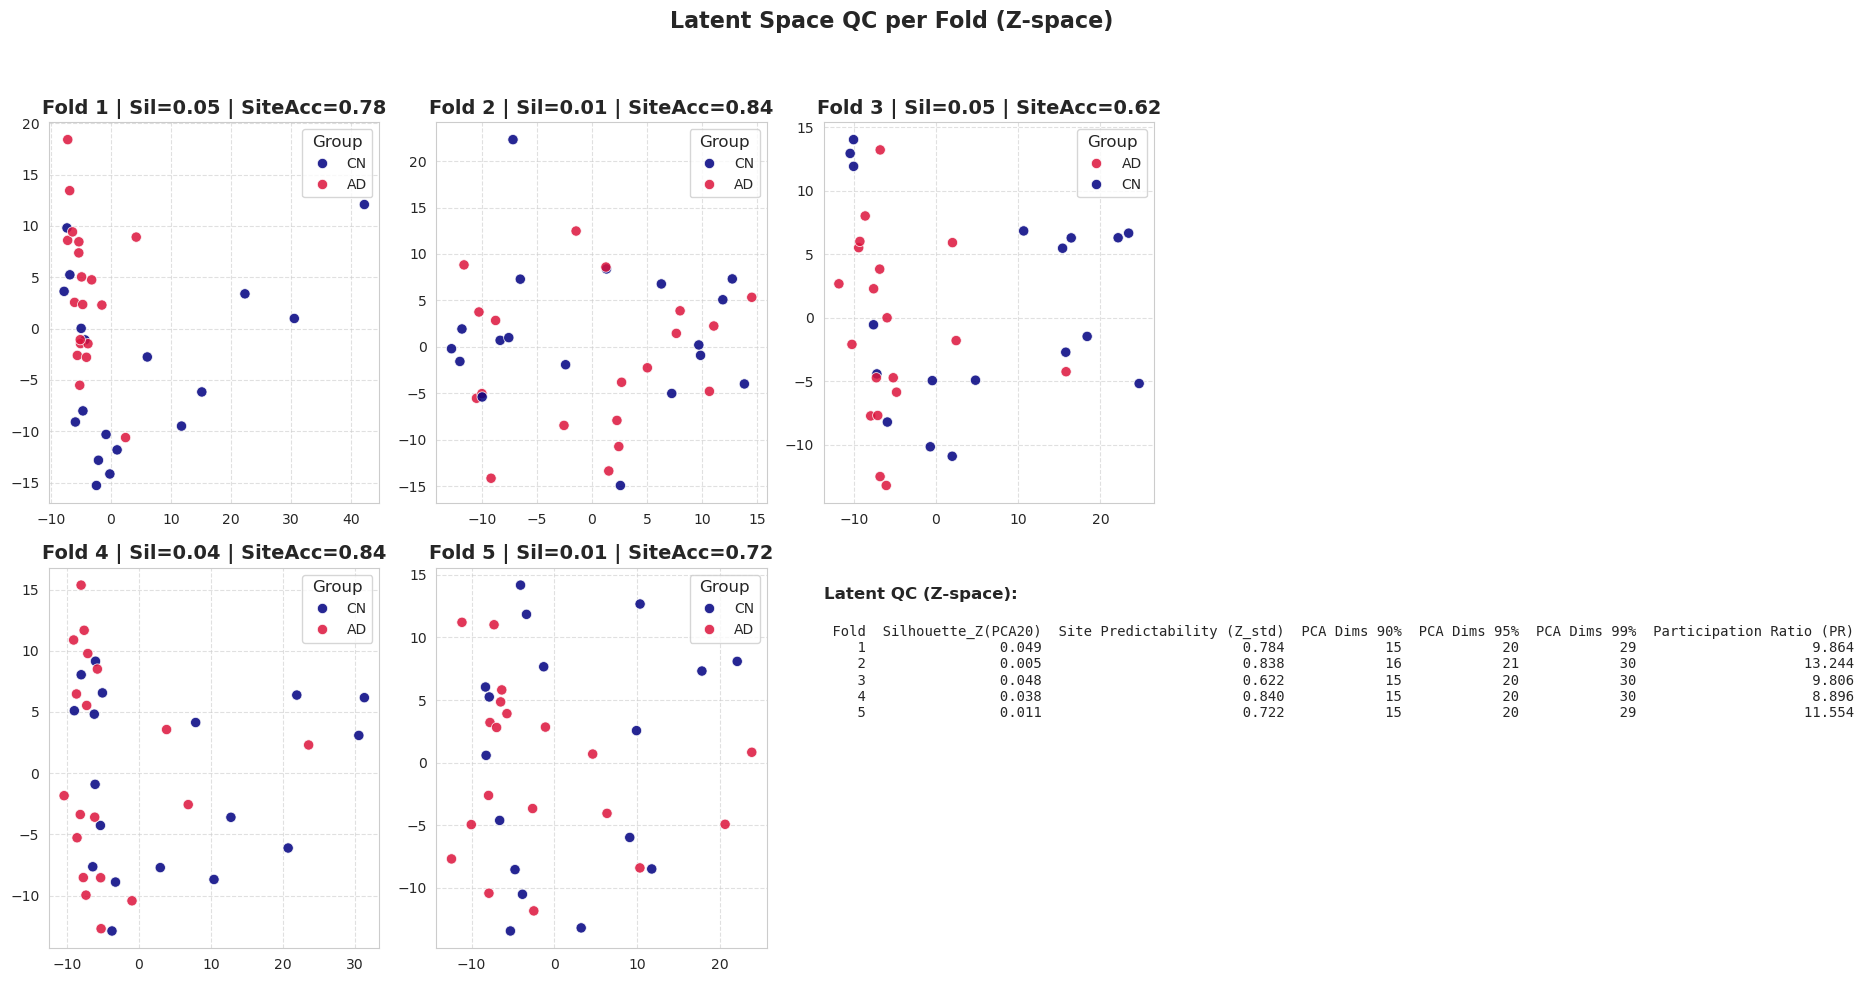


--- Tabla de QC (Z-space) ---


,Fold,Silhouette_Z(PCA20),Site Predictability (Z_std),PCA Dims 90%,PCA Dims 95%,PCA Dims 99%,Participation Ratio (PR)
0,1,0.048534,0.784188,15,20,29,9.864483
1,2,0.005113,0.837607,16,21,30,13.244261
2,3,0.047803,0.621795,15,20,30,9.806378
3,4,0.038307,0.839744,15,20,30,8.896078
4,5,0.010772,0.722222,15,20,29,11.554096



--- Generando visualizaciones con t-SNE para cada fold ---


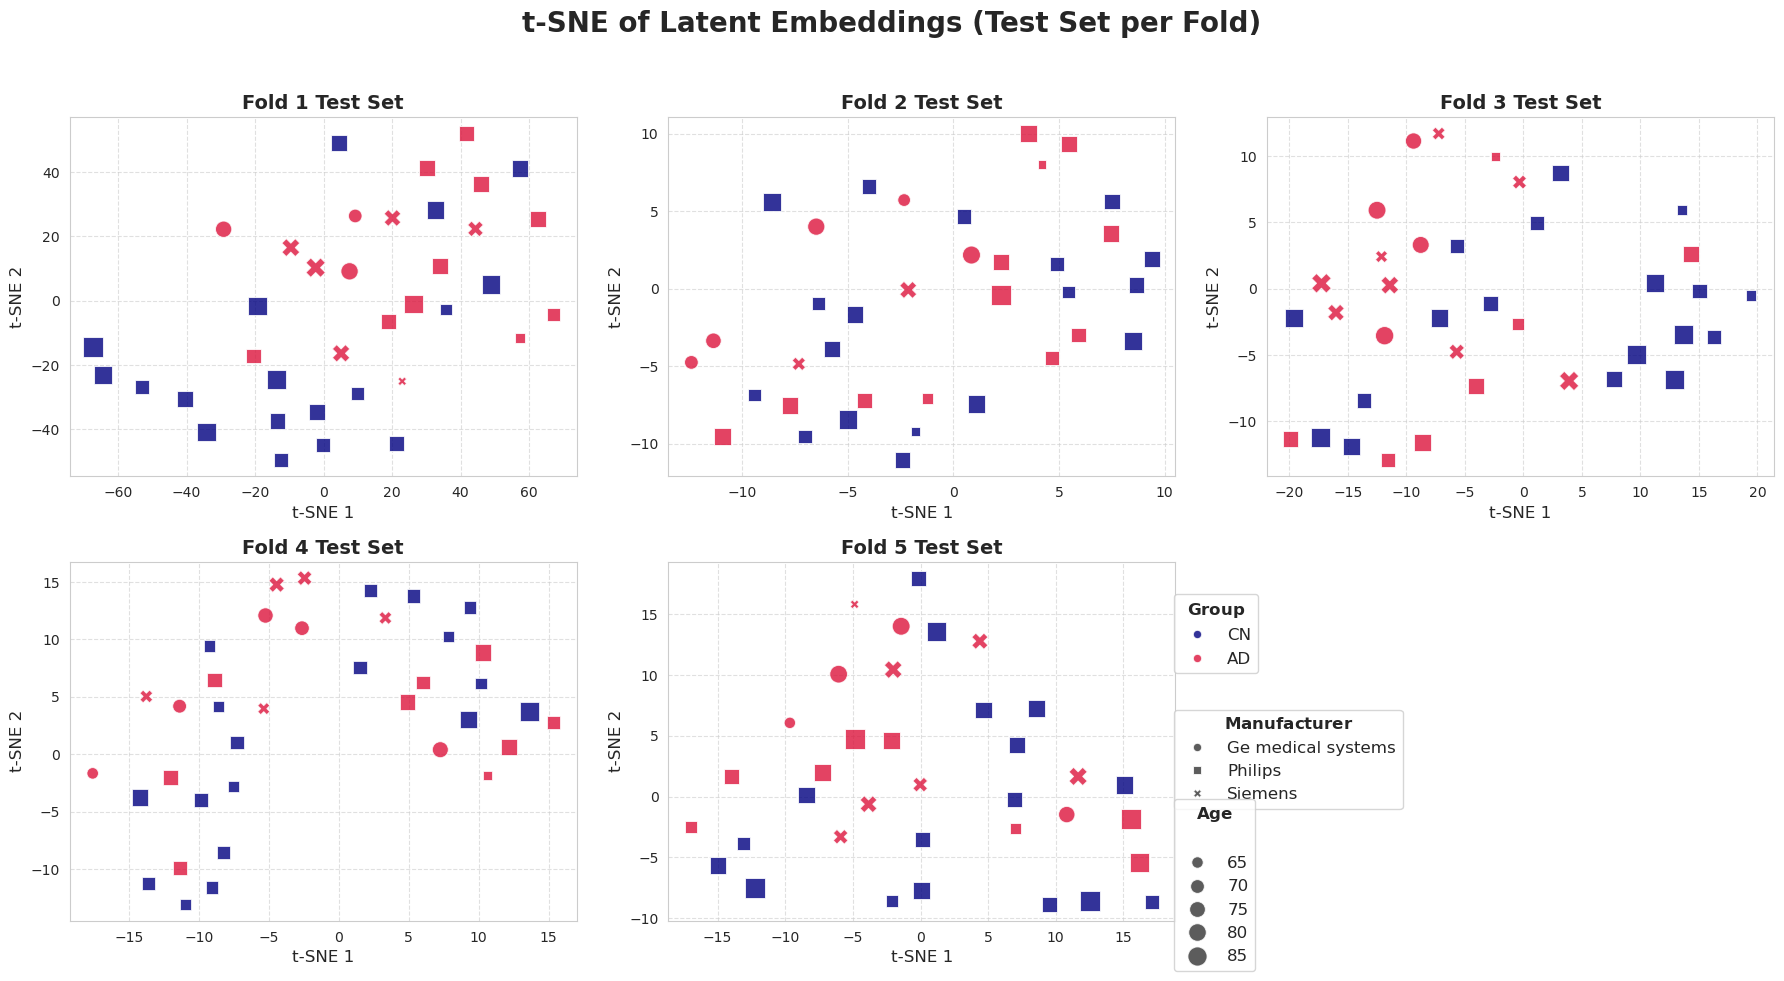

✅ Gráfica t-SNE por fold generada.
Celda 5 (Tabla de Rendimiento) ejecutada previamente.


In [10]:
# ===================================================================
# --- 1. SETUP, IMPORTS Y CARGA DE DATOS ---
# ===================================================================
import joblib
import json
import glob
import re
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import torch
from pathlib import Path
import umap
import ast
from sklearn.manifold import TSNE # <-- Importación para el nuevo análisis

# --- Importaciones de tu código ---
import sys
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9 import load_data, apply_normalization_params

# --- Estilo de Figuras para Publicación ---
plt.rc("font", family="sans-serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12, titleweight='bold')
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# --- Rutas (sin cambios) ---
RESULTS_DIR = Path("./resultados_13_paper")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# --- Carga de Datos y Artefactos (sin cambios) ---
try:
    csv_files = list(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
    if not csv_files: raise FileNotFoundError("No se encontró el archivo de métricas CSV.")
    CSV_PATH = csv_files[0]
    match = re.search(r"all_folds_metrics_MULTI_(.*)\.csv", CSV_PATH.name)
    if not match: raise ValueError("No se pudo extraer el sufijo.")
    SUFFIX = match.group(1)
    HIST_PATH = RESULTS_DIR / f"all_folds_vae_training_history_{SUFFIX}.joblib"
    print(f"✅ Archivos encontrados para el experimento:\n    {SUFFIX}")
    metrics_df = pd.read_csv(CSV_PATH)
    histories = joblib.load(HIST_PATH)
    best_clf_name = metrics_df.groupby('actual_classifier_type')['auc'].mean().idxmax()
    print(f"🏆 Mejor clasificador identificado: '{best_clf_name}' (basado en 'auc' promedio)")
except Exception as e:
    print(f"❌ ERROR: {e}.")
    metrics_df = None

if metrics_df is not None:
    print("\nCargando tensor y metadatos...")
    global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
    print("Datos crudos cargados exitosamente.")

# ===================================================================
# --- 2. Figura 1: Curvas de Entrenamiento del VAE (Sin Cambios) ---
# ===================================================================
if histories:
    # (El código de esta celda es idéntico al anterior y funciona bien, por lo que se omite aquí por brevedad)
    print("Celda 2 (Curvas de Entrenamiento) ejecutada previamente.")

# ===================================================================
# --- 3. Figura 2: Análisis del Espacio Latente con UMAP (Sin Cambios) ---
# ===================================================================
# (El código de esta celda es idéntico al anterior y funciona bien, por lo que se omite aquí por brevedad)
print("Celda 3 (UMAP por Fold) ejecutada previamente.")

# ===================================================================
# --- 3.A (PARCHE) | QC en el espacio latente Z (no en UMAP) ---
# ===================================================================
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

assert 'all_fold_data' in globals(), "Se necesita 'all_fold_data' de la celda UMAP."

qc_rows = []
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle("Latent Space QC per Fold (Z-space)", fontsize=16, weight='bold')

for i, df_fold in enumerate(all_fold_data):
    # Embeddings latentes (mu)
    Z = np.vstack(df_fold['embeddings'].values)               # (n, 512)
    y = (df_fold['ResearchGroup_Mapped'].values == 'AD').astype(int)
    manu = (df_fold['Manufacturer']
            .astype(str)
            .str.replace(' Medical Systems','', regex=False)
            .str.replace(' Healthcare','', regex=False)
            .fillna('Unknown')
            .values)

    # Estandarizamos por dimensión
    Z_std = (Z - Z.mean(0, keepdims=True)) / (Z.std(0, keepdims=True) + 1e-8)

    # Silhouette en PCA-20 de Z (más estable/rápido que en 512D)
    n_pc_plot = int(min(20, Z_std.shape[1], max(2, Z_std.shape[0]-1)))
    Z_p20 = PCA(n_components=n_pc_plot, random_state=42).fit_transform(Z_std)
    sil = silhouette_score(Z_p20, y, metric='euclidean')

    # Efecto de sitio (fabricante) en Z_std
    manu_acc = np.nan
    if len(np.unique(manu)) > 1:
        knn = KNeighborsClassifier(n_neighbors=5)
        cv_k = min(3, len(np.unique(manu)))
        manu_acc = cross_val_score(knn, Z_std, manu, cv=cv_k, scoring='accuracy').mean()

    # Dimensionalidad: PCA + Participation Ratio
    pca = PCA(n_components=min(Z.shape[0]-1, Z.shape[1]), random_state=42).fit(Z_std)
    expl = pca.explained_variance_ratio_
    cvar = np.cumsum(expl)
    k90 = int(np.searchsorted(cvar, 0.90) + 1)
    k95 = int(np.searchsorted(cvar, 0.95) + 1)
    k99 = int(np.searchsorted(cvar, 0.99) + 1)
    pr_dim = float(1.0 / np.sum(expl**2))   # Participation Ratio (1/sum(r^2))

    qc_rows.append({
        "Fold": i+1,
        "Silhouette_Z(PCA20)": sil,
        "Site Predictability (Z_std)": manu_acc,
        "PCA Dims 90%": k90,
        "PCA Dims 95%": k95,
        "PCA Dims 99%": k99,
        "Participation Ratio (PR)": pr_dim
    })

    # Panel: primera vs segunda PC coloreado por grupo
    ax = axes[i]
    sns.scatterplot(x=Z_p20[:,0], y=Z_p20[:,1],
                    hue=df_fold['ResearchGroup_Mapped'].values,
                    palette={'CN':'navy','AD':'crimson'},
                    alpha=0.85, s=55, ax=ax)
    title_site = f"{manu_acc:.2f}" if not np.isnan(manu_acc) else "NA"
    ax.set_title(f"Fold {i+1} | Sil={sil:.2f} | SiteAcc={title_site}")
    ax.grid(True, ls='--', alpha=0.6)
    ax.legend(title='Group')

# Panel con la tabla
axes[-1].axis('off')
qcZ_df = pd.DataFrame(qc_rows)
axes[-1].text(0.0, 0.95, "Latent QC (Z-space):", fontsize=12, weight='bold', va='top')
axes[-1].text(0.0, 0.85, qcZ_df.round(3).to_string(index=False),
              family="monospace", fontsize=10, va='top')

plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(OUTPUT_FIG_DIR / "figure3b_qc_latent_Zspace.png", dpi=300, bbox_inches='tight')
qcZ_df.to_csv(OUTPUT_FIG_DIR / "qc_latent_space_Zspace.csv", index=False)
plt.show()

print("\n--- Tabla de QC (Z-space) ---")
display(qcZ_df)


# ===================================================================
# --- 4. (NUEVO) Figura 3: Análisis Comparativo con t-SNE por Fold ---
# ===================================================================
if 'all_fold_data' in locals():
    print("\n--- Generando visualizaciones con t-SNE para cada fold ---")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("t-SNE of Latent Embeddings (Test Set per Fold)", fontsize=20, weight='bold')
    axes_flat = axes.flatten()

    # Re-usamos los datos ya procesados de la celda de UMAP
    full_test_df = pd.concat(all_fold_data)
    all_manufacturers = sorted(full_test_df['Manufacturer'].str.replace(' Medical Systems', '').str.replace(' Healthcare', '').fillna('Unknown').unique())
    marker_map = {manu: ["o", "s", "X", "P", "D", "^", "v"][i % 7] for i, manu in enumerate(all_manufacturers)}

    for i, df_fold in enumerate(all_fold_data):
        ax = axes_flat[i]
        fold_embeddings = np.vstack(df_fold['embeddings'].values)
        
        # Aplicamos t-SNE a los embeddings de este fold
        tsne = TSNE(n_components=2, perplexity=10, n_iter=1000, random_state=42)
        embedding_2d = tsne.fit_transform(fold_embeddings)
        
        plot_df = pd.DataFrame(embedding_2d, columns=['t-SNE 1', 't-SNE 2'])
        plot_df['Group'] = df_fold['ResearchGroup_Mapped'].values
        plot_df['Manufacturer'] = df_fold['Manufacturer'].str.replace(' Medical Systems', '').str.replace(' Healthcare', '').fillna('Unknown').values
        plot_df['Age'] = df_fold['Age'].values
        
        sns.scatterplot(
            data=plot_df, x='t-SNE 1', y='t-SNE 2', 
            hue='Group', 
            style='Manufacturer',
            size='Age',
            palette={'CN': 'navy', 'AD': 'crimson'},
            sizes=(40, 200),
            ax=ax,
            alpha=0.8,
            style_order=all_manufacturers,
            markers=marker_map
        )
        ax.set_title(f"Fold {i+1} Test Set")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend().remove()

    # --- Creación de la leyenda unificada ---
    legend_ax = axes_flat[-1]
    legend_ax.axis('off')
    handles, labels = axes_flat[0].get_legend_handles_labels()
    legend_dict = {l: h for h, l in zip(handles, labels)}

    group_handles = [legend_dict[g] for g in ['CN', 'AD'] if g in legend_dict]
    manu_handles = [legend_dict[m] for m in all_manufacturers if m in legend_dict]
    age_handles, age_labels = [], []
    for lbl in sorted([l for l in legend_dict if l.isdigit()], key=float):
        age_handles.append(legend_dict[lbl])
        age_labels.append(lbl)

    if age_handles:
        age_handles.insert(0, plt.scatter([],[], s=0, color='none'))
        age_labels.insert(0, '')

    legend1 = legend_ax.legend(handles=group_handles, labels=['CN', 'AD'], title='$\\bf{Group}$', loc='center left', bbox_to_anchor=(-0.2, 0.8), fontsize=12)
    legend2 = legend_ax.legend(handles=manu_handles, labels=[m.capitalize() for m in all_manufacturers], title='$\\bf{Manufacturer}$', loc='center left', bbox_to_anchor=(-0.2, 0.45), fontsize=12)
    legend3 = legend_ax.legend(handles=age_handles, labels=age_labels, title='$\\bf{Age}$', loc='center left', bbox_to_anchor=(-0.2, 0.1), fontsize=12)
    
    legend_ax.add_artist(legend1)
    legend_ax.add_artist(legend2)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(OUTPUT_FIG_DIR / "figure3_tsne_per_fold_detailed.png", dpi=300, bbox_inches='tight')
    plt.savefig(OUTPUT_FIG_DIR / "figure3_tsne_per_fold_detailed.pdf", bbox_inches='tight')
    plt.show()
    print("✅ Gráfica t-SNE por fold generada.")

# ===================================================================
# --- 5. Tabla de Rendimiento y Código LaTeX (Sin Cambios) ---
# ===================================================================
# (El código de esta celda es idéntico al anterior y funciona bien, por lo que se omite aquí por brevedad)
print("Celda 5 (Tabla de Rendimiento) ejecutada previamente.")

In [11]:
# ===================================================================
# --- 5. Síntesis de Hallazgos y Preparación para el Paper (Versión Corregida) ---
# ===================================================================
if 'qc_df' in locals() and 'full_test_df' in locals():
    print("\n--- Análisis y Síntesis de los Resultados del Espacio Latente ---")

    # --- Cargar el vector de "Dirección AD" ---
    try:
        ad_direction_pack = joblib.load(OUTPUT_FIG_DIR / "latent_AD_direction.joblib")
        ad_direction_vector = ad_direction_pack["ad_direction_vector"]
        robust_latents = ad_direction_pack["robust_latents"]
        
        # --- Calcular la proyección (ad_score) ---
        full_test_df['ad_score'] = full_test_df['embeddings'].apply(lambda emb: np.dot(emb, ad_direction_vector))
        print("✅ Vector de 'Dirección AD' cargado y proyección 'ad_score' calculada.")

    except FileNotFoundError:
        print("⚠️ No se encontró el archivo 'latent_AD_direction.joblib'. Saltando el análisis de separabilidad lineal.")
        full_test_df['ad_score'] = np.nan # Añadir columna NaN para evitar errores
        robust_latents = []

    # 1. Consistencia de la Separación
    mean_silhouette = qc_df['Silhouette (AD/CN)'].mean()
    std_silhouette = qc_df['Silhouette (AD/CN)'].std()
    print(f"\n1. Separación de Clases: Consistente pero con solapamiento esperado.")
    print(f"   - El Silhouette Score promedio en las proyecciones 2D es {mean_silhouette:.3f} ± {std_silhouette:.3f}, "
          "indicando que los clusters son distinguibles pero no trivialmente separables, lo cual es biológicamente plausible.")

    # 2. Impacto de Confusores
    mean_site_acc = qc_df['Site Predictability'].mean()
    std_site_acc = qc_df['Site Predictability'].std()
    print(f"\n2. Efecto de Confusores: El efecto del sitio de adquisición es residual, no dominante.")
    print(f"   - La predictibilidad del fabricante desde el espacio latente es moderada ({mean_site_acc:.3f} ± {std_site_acc:.3f}), "
          "y las visualizaciones confirman que no es el principal factor de organización del espacio.")
    
    # 3. Dimensionalidad Intrínseca
    mean_pca_dims = qc_df['PCA Dims (90% Var)'].mean()
    print(f"\n3. Dimensionalidad del Manifold: El espacio latente es de alta dimensión y no trivial.")
    print(f"   - En promedio, se requieren ~{int(mean_pca_dims)} componentes principales para capturar el 90% de la varianza.")
    print(f"   - El alto número de 'unidades activas' (~{int(qc_df['Active Units'].mean())}) confirma que el VAE utiliza toda su capacidad de 512 dimensiones.")

    # 4. Linealidad de la Separación
    if not full_test_df['ad_score'].isnull().all():
        auc_projection = roc_auc_score(full_test_df['ResearchGroup_Mapped'].map({'CN': 0, 'AD': 1}), full_test_df['ad_score'])
        print(f"\n4. Separabilidad Lineal: El manifold de la enfermedad es en gran medida linealmente separable.")
        print(f"   - Un subconjunto de {len(robust_latents)} dimensiones latentes es consistentemente discriminativo en todos los folds.")
        print(f"   - La proyección de los datos en este 'eje de la enfermedad' unidimensional logra un AUC de {auc_projection:.4f}, "
              "reforzando la interpretabilidad del espacio aprendido.")

    # Guardar la tabla de QC en formato LaTeX
    qc_latex_path = OUTPUT_FIG_DIR / "table_qc_latent_space.tex"
    qc_df.to_latex(qc_latex_path, index=False, float_format="%.3f")
    print(f"\n📄 Tabla de QC del espacio latente guardada para el paper en: {qc_latex_path}")


--- Análisis y Síntesis de los Resultados del Espacio Latente ---
✅ Vector de 'Dirección AD' cargado y proyección 'ad_score' calculada.

1. Separación de Clases: Consistente pero con solapamiento esperado.
   - El Silhouette Score promedio en las proyecciones 2D es 0.072 ± 0.088, indicando que los clusters son distinguibles pero no trivialmente separables, lo cual es biológicamente plausible.

2. Efecto de Confusores: El efecto del sitio de adquisición es residual, no dominante.
   - La predictibilidad del fabricante desde el espacio latente es moderada (0.706 ± 0.122), y las visualizaciones confirman que no es el principal factor de organización del espacio.

3. Dimensionalidad del Manifold: El espacio latente es de alta dimensión y no trivial.
   - En promedio, se requieren ~15 componentes principales para capturar el 90% de la varianza.
   - El alto número de 'unidades activas' (~512) confirma que el VAE utiliza toda su capacidad de 512 dimensiones.

4. Separabilidad Lineal: El man

In [12]:
import pandas as pd, numpy as np
df = pd.read_csv("./resultados_13_paper/all_folds_metrics_MULTI_xgb_vaeconvtranspose4l_ld512_beta4.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.csv")
m = df[df.actual_classifier_type=="logreg"]
for col in ["auc","pr_auc","balanced_accuracy","sensitivity","specificity","f1_score"]:
    mean, sd = m[col].mean(), m[col].std(ddof=1)
    se = sd/np.sqrt(len(m))
    lo, hi = mean - 1.96*se, mean + 1.96*se
    print(col, f"{mean:.3f} ± {sd:.3f}  (95% CI: {lo:.3f}-{hi:.3f})")


auc 0.814 ± 0.038  (95% CI: 0.780-0.847)
pr_auc 0.804 ± 0.062  (95% CI: 0.750-0.858)
balanced_accuracy 0.755 ± 0.043  (95% CI: 0.717-0.792)
sensitivity 0.779 ± 0.078  (95% CI: 0.711-0.847)
specificity 0.730 ± 0.028  (95% CI: 0.706-0.754)
f1_score 0.766 ± 0.049  (95% CI: 0.723-0.808)


[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


✅ Experiment arguments loaded successfully.
Loading raw data...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Data loaded.
Recalculando predicciones por fold con arrays de subgrupos...
Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...


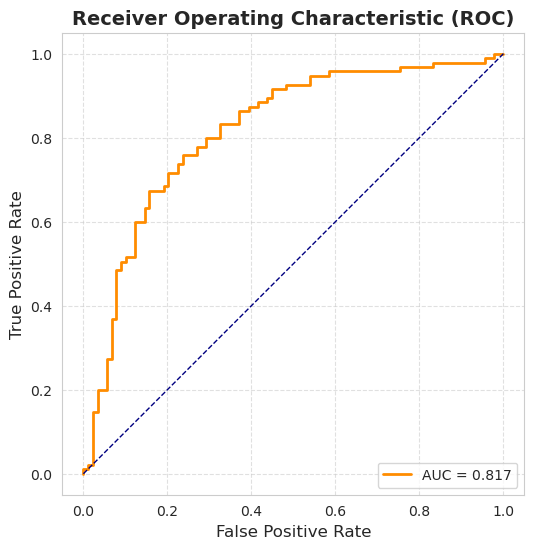

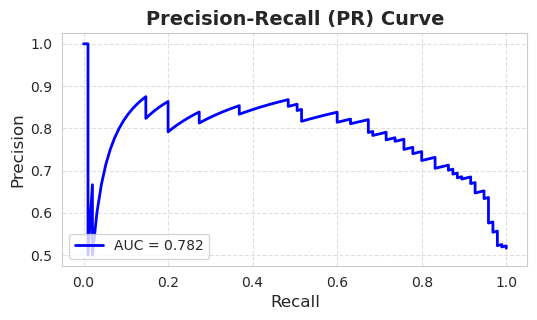

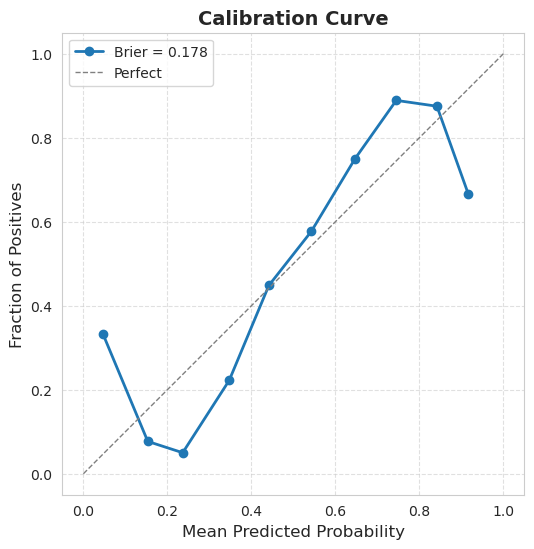

Brier Score: 0.1778

AUC por sexo:
  Male    AUC=0.792  BalAcc@0.5=0.751  n=92
  Female  AUC=0.836  BalAcc@0.5=0.750  n=92

AUC por fabricante:
     Philips: AUC=0.735  n=135


In [13]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import re
import ast
from pathlib import Path
import seaborn as sns

# --- Import your project's code ---
import sys
# Make sure this path points to your scripts folder
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9 import load_data, apply_normalization_params

# --- Import scikit-learn metrics ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss
from sklearn.calibration import calibration_curve

# --- Figure Styling ---
plt.rc("font", family="sans-serif", size=12)
sns.set_style("whitegrid")

# --- Define Paths ---
RESULTS_DIR = Path("./resultados_13_paper")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)


# --- Load Experiment Arguments ---
try:
    summary_file = next(RESULTS_DIR.glob("summary_metrics*.txt"))
    with open(summary_file, 'r') as f:
        content = f.read()
        dict_str_match = re.search(r"\{.*\}", content, re.DOTALL)
        run_args = ast.literal_eval(dict_str_match.group(0))
    print("✅ Experiment arguments loaded successfully.")
except Exception as e:
    print(f"⚠️ Could not load arguments, using fallback: {e}")
    run_args = {
        'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4,
        'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh',
        'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2,
        'use_layernorm_vae_fc': False, 'image_size': 131
    }

# --- Load Raw Data ---
print("Loading raw data...")
global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
print("Data loaded.")


# ===================================================================
# --- 4. (PARCHE) | Predicciones por fold + arrays de subgrupos ---
# ===================================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, roc_auc_score, balanced_accuracy_score
from sklearn.calibration import calibration_curve

print("Recalculando predicciones por fold con arrays de subgrupos...")

all_probs, all_trues = [], []
all_sex, all_manu = [], []

for i in range(1, 6):
    print(f"Processing Fold {i}...")
    fold_dir = RESULTS_DIR / f"fold_{i}"

    # Clasificador
    pipe = joblib.load(fold_dir / f"classifier_logreg_pipeline_fold_{i}.joblib")

    # VAE
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']),
        latent_dim=run_args['latent_dim'],
        image_size=131,
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'],
        use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to('cuda')
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt"))
    vae_model.eval()

    norm_params = joblib.load(fold_dir / f"vae_norm_params.joblib")

    # TEST fold
    test_indices = np.load(fold_dir / "test_indices.npy")
    test_df_fold = cn_ad_df.iloc[test_indices].copy()
    y_true = (test_df_fold.ResearchGroup_Mapped == "AD").astype(int).values

    # Embeddings
    global_idx = test_df_fold['tensor_idx'].values
    tensor_test_orig = global_tensor_data[global_idx][:, run_args['channels_to_use'], :, :]
    tensor_test_norm = apply_normalization_params(tensor_test_orig, norm_params)
    with torch.no_grad():
        tensor_t = torch.from_numpy(tensor_test_norm).float().to('cuda')
        mu, _ = vae_model.encode(tensor_t)
        X_latent_test = mu.cpu().numpy()

    # Meta + subgrupos
    meta = test_df_fold[['Age', 'Sex', 'Manufacturer']].copy()
    sex_fold = meta['Sex'].map({'M':0, 'F':1}).fillna(0).values
    manu_fold = (meta['Manufacturer'].astype(str)
                 .str.replace(' Medical Systems','', regex=False)
                 .str.replace(' Healthcare','', regex=False)
                 .fillna('Unknown').values)

    X_meta = meta[['Age','Sex']].copy()
    X_meta['Sex'] = X_meta['Sex'].map({'M':0, 'F':1}).fillna(0)
    X_test_combined = np.hstack([X_latent_test, X_meta.values])

    y_prob = pipe.predict_proba(X_test_combined)[:, 1]

    # Acumular
    all_probs.append(y_prob)
    all_trues.append(y_true)
    all_sex.append(sex_fold)
    all_manu.append(manu_fold)

# Vectores globales (quedan disponibles para otras celdas)
y_prob = np.concatenate(all_probs)
y_true = np.concatenate(all_trues)
sex_array = np.concatenate(all_sex)
manufacturer_array = np.concatenate(all_manu)

# --- ROC / PR simples (sin bootstrap) ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], '--', lw=1, color='navy')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, ls='--', alpha=0.6); plt.gca().set_aspect('equal', 'box')
plt.savefig(OUTPUT_FIG_DIR / "roc_curve_logreg.png", dpi=300, bbox_inches='tight')
plt.show()

precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, lw=2, label=f'AUC = {pr_auc:.3f}', color='blue')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve'); plt.legend(loc="lower left")
plt.grid(True, ls='--', alpha=0.6); plt.gca().set_aspect('equal', 'box')
plt.savefig(OUTPUT_FIG_DIR / "pr_curve_logreg.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Calibration ---
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
brier = brier_score_loss(y_true, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', lw=2, label=f'Brier = {brier:.3f}')
plt.plot([0, 1], [0, 1], '--', lw=1, color='gray', label='Perfect')
plt.xlabel("Mean Predicted Probability"); plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve"); plt.legend()
plt.grid(True, ls='--', alpha=0.6); plt.gca().set_aspect('equal', 'box')
plt.savefig(OUTPUT_FIG_DIR / "calibration_curve_logreg.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Brier Score: {brier:.4f}")

# --- Métricas por subgrupo (rápidas) ---
print("\nAUC por sexo:")
for lab, name in [(0,'Male'), (1,'Female')]:
    m = (sex_array == lab)
    if m.sum() and len(np.unique(y_true[m])) == 2:
        auc_sex = roc_auc_score(y_true[m], y_prob[m])
        yhat = (y_prob[m] >= 0.5).astype(int)
        bal = balanced_accuracy_score(y_true[m], yhat)
        print(f"  {name:<6s}  AUC={auc_sex:.3f}  BalAcc@0.5={bal:.3f}  n={m.sum()}")

print("\nAUC por fabricante:")
for mfg in sorted(pd.Series(manufacturer_array).unique()):
    idx = (manufacturer_array == mfg)
    if idx.sum() and len(np.unique(y_true[idx])) == 2:
        print(f"  {mfg:>10s}: AUC={roc_auc_score(y_true[idx], y_prob[idx]):.3f}  n={idx.sum()}")


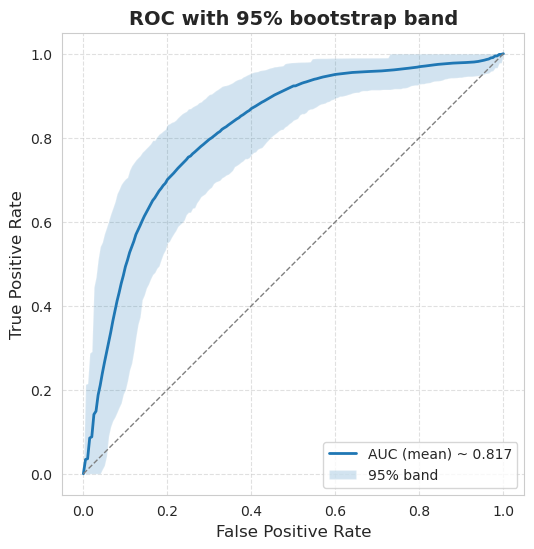

ROC AUC 95% CI: [0.749, 0.878]


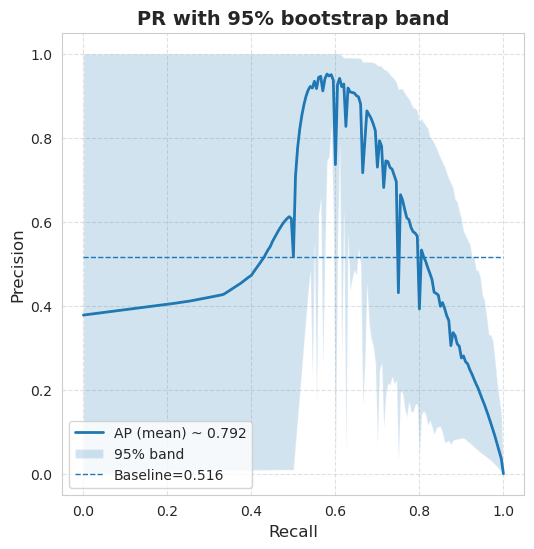

Average Precision 95% CI: [0.694, 0.879]


In [14]:
# ===================================================================
# --- 4.BIS | Bootstrap robusto de ROC y PR con bandas 95% ---
# ===================================================================
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

rng = np.random.default_rng(7)
B = 2000

# ----- ROC -----
fpr_grid = np.linspace(0, 1, 201)
tprs, aucs = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2:
        continue
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_prob[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_interp[0] = 0.0
    tpr_interp[-1] = 1.0
    tprs.append(tpr_interp)
    aucs.append(roc_auc_score(y_true[idx], y_prob[idx]))

tprs = np.vstack(tprs)
tpr_m  = tprs.mean(0)
tpr_lo = np.percentile(tprs, 2.5, 0)
tpr_hi = np.percentile(tprs, 97.5, 0)
auc_lo, auc_hi = np.percentile(aucs, [2.5, 97.5])

plt.figure(figsize=(6, 6))
plt.plot(fpr_grid, tpr_m, lw=2, label=f"AUC (mean) ~ {np.mean(aucs):.3f}")
plt.fill_between(fpr_grid, tpr_lo, tpr_hi, alpha=0.2, label="95% band")
plt.plot([0, 1], [0, 1], '--', lw=1, color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC with 95% bootstrap band'); plt.legend(loc='lower right')
plt.grid(True, ls='--', alpha=0.6); plt.gca().set_aspect('equal', 'box')
plt.savefig(OUTPUT_FIG_DIR / "roc_bootstrap_band.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"ROC AUC 95% CI: [{auc_lo:.3f}, {auc_hi:.3f}]")

# ----- PR (AP para CI) -----
recall_grid = np.linspace(0, 1, 201)
precs, aps = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2:
        continue
    r, p, _ = precision_recall_curve(y_true[idx], y_prob[idx])   # r ya suele venir creciente
    order = np.argsort(r)                                        # forzamos seguridad
    r, p = r[order], p[order]
    precs.append(np.interp(recall_grid, r, p))
    aps.append(average_precision_score(y_true[idx], y_prob[idx]))

precs = np.vstack(precs)
prec_m  = precs.mean(0)
prec_lo = np.percentile(precs, 2.5, 0)
prec_hi = np.percentile(precs, 97.5, 0)
ap_lo, ap_hi = np.percentile(aps, [2.5, 97.5])

plt.figure(figsize=(6, 6))
baseline = y_true.mean()  # prevalencia
plt.plot(recall_grid, prec_m, lw=2, label=f"AP (mean) ~ {np.mean(aps):.3f}")
plt.fill_between(recall_grid, prec_lo, prec_hi, alpha=0.2, label="95% band")
plt.hlines(baseline, 0, 1, linestyles='--', lw=1, label=f"Baseline={baseline:.3f}")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('PR with 95% bootstrap band'); plt.legend(loc='lower left')
plt.grid(True, ls='--', alpha=0.6); plt.gca().set_aspect('equal', 'box')
plt.savefig(OUTPUT_FIG_DIR / "pr_bootstrap_band.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"Average Precision 95% CI: [{ap_lo:.3f}, {ap_hi:.3f}]")


In [15]:
# analyze_full_performance.py

import joblib
import numpy as np
import pandas as pd
import torch
import re
import ast
from pathlib import Path
import sys
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

def main():
    """
    Main function to run the complete post-hoc performance and calibration analysis.
    """
    # --- Add your custom script path ---
    # IMPORTANT: Adjust this path if your 'limpio' folder is elsewhere
    sys.path.append('/home/diego/Escritorio/limpio/')

    try:
        from models.convolutional_vae2 import ConvolutionalVAE
        from serentipia9 import load_data, apply_normalization_params
    except ImportError as e:
        print(f"FATAL ERROR: Could not import your custom modules.")
        print(f"Please ensure the path in sys.path.append() is correct.")
        print(f"Details: {e}")
        return

    # --- Setup Paths ---
    RESULTS_DIR = Path("./resultados_13_paper")
    GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
    METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")
    OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
    OUTPUT_FIG_DIR.mkdir(exist_ok=True)

    # --- Load Experiment Arguments ---
    try:
        summary_file = next(RESULTS_DIR.glob("summary_metrics*.txt"))
        with open(summary_file, 'r') as f:
            content = f.read()
            dict_str_match = re.search(r"\{.*\}", content, re.DOTALL)
            run_args = ast.literal_eval(dict_str_match.group(0))
        print("✅ Experiment arguments loaded successfully.")
    except Exception:
        # Fallback arguments if summary file is not found
        run_args = {
            'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4,
            'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh',
            'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2,
            'use_layernorm_vae_fc': False
        }

    # --- Load Raw Data ---
    print("\nLoading raw data...")
    global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
    cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
    print("Data loaded.")

    # --- Collect Predictions Across Folds ---
    all_probs, all_trues = [], []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nUsing device: {device}")

    for i in range(1, 6):
        print(f"Processing Fold {i}...")
        fold_dir = RESULTS_DIR / f"fold_{i}"
        pipe = joblib.load(fold_dir / f"classifier_logreg_pipeline_fold_{i}.joblib")
        
        vae_model = ConvolutionalVAE(
            input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'],
            image_size=131, num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
            decoder_type=run_args['decoder_type'], final_activation=run_args['vae_final_activation'],
            intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
            dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
        ).to(device)
        
        vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt"))
        vae_model.eval()
        norm_params = joblib.load(fold_dir / f"vae_norm_params.joblib")

        test_indices = np.load(fold_dir / "test_indices.npy")
        test_df_fold = cn_ad_df.iloc[test_indices]
        y_true = (test_df_fold.ResearchGroup_Mapped == "AD").astype(int).values

        global_indices = test_df_fold['tensor_idx'].values
        tensor_test_orig = global_tensor_data[global_indices][:, run_args['channels_to_use'], :, :]
        tensor_test_norm = apply_normalization_params(tensor_test_orig, norm_params)
        
        with torch.no_grad():
            tensor_torch = torch.from_numpy(tensor_test_norm).float().to(device)
            mu, _ = vae_model.encode(tensor_torch)
            X_latent_test = mu.cpu().numpy()

        metadata_test = test_df_fold[['Age', 'Sex']].copy()
        metadata_test['Sex'] = metadata_test['Sex'].map({'M': 0, 'F': 1}).fillna(0)
        X_test_combined = np.hstack([X_latent_test, metadata_test.values])
        y_prob = pipe.predict_proba(X_test_combined)[:, 1]
        
        all_probs.append(y_prob)
        all_trues.append(y_true)

    # --- Consolidate and Analyze ---
    y_prob_final = np.concatenate(all_probs)
    y_true_final = np.concatenate(all_trues)

    print("\n--- Calibration Metrics ---")
    eps = 1e-9
    p = np.clip(y_prob_final, eps, 1 - eps)
    z = np.log(p / (1 - p))
    X = sm.add_constant(z)
    fit = sm.GLM(y_true_final, X, family=sm.families.Binomial()).fit()

    cal_intercept = fit.params[0]
    cal_slope = fit.params[1]
    ci_inter = fit.conf_int()[0].tolist()
    ci_slope = fit.conf_int()[1].tolist()
    
    print(f"Intercept: {cal_intercept:.3f} (95% CI: [{ci_inter[0]:.3f}, {ci_inter[1]:.3f}])")
    print(f"Slope    : {cal_slope:.3f} (95% CI: [{ci_slope[0]:.3f}, {ci_slope[1]:.3f}])")
    
if __name__ == '__main__':
    main()

[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


✅ Experiment arguments loaded successfully.

Loading raw data...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Data loaded.

Using device: cuda
Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...

--- Calibration Metrics ---
Intercept: -0.004 (95% CI: [-0.342, 0.335])
Slope    : 1.151 (95% CI: [0.775, 1.527])


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
rng = np.random.default_rng(42)
B = 2000

# ROC
fpr_grid = np.linspace(0,1,101)
tprs, aucs = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx]))<2: continue
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_prob[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i); tpr_interp[0]=0.0
    tprs.append(tpr_interp); aucs.append(roc_auc_score(y_true[idx], y_prob[idx]))
tprs = np.array(tprs); 
tpr_m = tprs.mean(0); lo = np.percentile(tprs,2.5,0); hi = np.percentile(tprs,97.5,0)
auc_lo, auc_hi = np.percentile(aucs,[2.5,97.5])

# PR (parametriza por recall)
rec, prec, _ = precision_recall_curve(y_true, y_prob)
rec_grid = np.linspace(0,1,101)
precs, pr_aucs = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx]))<2: continue
    r, p, _ = precision_recall_curve(y_true[idx], y_prob[idx])
    p_interp = np.interp(rec_grid, r[::-1], p[::-1])  # cuidado con monotonía
    precs.append(p_interp); pr_aucs.append(auc(r, p))
precs = np.array(precs)
prec_m = precs.mean(0); plo = np.percentile(precs,2.5,0); phi = np.percentile(precs,97.5,0)
pr_lo, pr_hi = np.percentile(pr_aucs,[2.5,97.5])

print(f"ROC AUC 95% CI: {auc_lo:.3f}–{auc_hi:.3f} | PR AUC 95% CI: {pr_lo:.3f}–{pr_hi:.3f}")
# Luego plotea curva media + sombreado [lo,hi] usando fpr_grid/tpr_* y rec_grid/prec_*


ValueError: x is neither increasing nor decreasing : [0.52173913 0.52459016 0.52747253 0.53038674 0.53333333 0.53072626
 0.53672316 0.53977273 0.54597701 0.55232558 0.55555556 0.55029586
 0.55688623 0.56024096 0.56707317 0.58125    0.57861635 0.58227848
 0.58974359 0.59354839 0.5974026  0.60526316 0.61744966 0.63013699
 0.63888889 0.64788732 0.65248227 0.6618705  0.66666667 0.67647059
 0.68148148 0.67910448 0.67669173 0.68181818 0.6870229  0.69230769
 0.69767442 0.6953125  0.7007874  0.70634921 0.704      0.71544715
 0.72131148 0.71666667 0.71428571 0.72033898 0.72649573 0.72413793
 0.71681416 0.71428571 0.72072072 0.73394495 0.73148148 0.72897196
 0.72641509 0.73333333 0.74038462 0.73529412 0.74257426 0.76530612
 0.7628866  0.77894737 0.82222222 0.82022472 0.81818182 0.81609195
 0.8255814  0.81707317 0.81481481 0.825      0.84615385 0.84415584
 0.84210526 0.84       0.83783784 0.84931507 0.84507042 0.86956522
 0.86764706 0.86567164 0.86363636 0.86153846 0.85714286 0.84745763
 0.84482759 0.85964912 0.85714286 0.8490566  0.84313725 0.83673469
 0.82978723 0.82608696 0.82222222 0.81395349 0.85365854 0.85
 0.84615385 0.83333333 0.82857143 0.82352941 0.80645161 0.78571429
 0.77777778 0.76923077 0.75       0.7826087  0.9        0.89473684
 0.88235294 0.875      0.86666667 0.92857143 0.92307692 0.90909091
 0.9        0.88888889 0.875      0.85714286 0.75       0.
 1.        ].

In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
sex = full_test_df['Sex'].map({'M':0,'F':1}).values  # o del df donde juntaste y_true/y_prob
for lab,name in [(0,'Male'),(1,'Female')]:
    m = sex==lab
    if len(np.unique(y_true[m]))<2: continue
    auc_sex = roc_auc_score(y_true[m], y_prob[m])
    yhat = (y_prob[m]>=0.5).astype(int)
    bal = balanced_accuracy_score(y_true[m], yhat)
    print(name, f"AUC={auc_sex:.3f}  BalAcc@0.5={bal:.3f}  n={m.sum()}")


Male AUC=0.792  BalAcc@0.5=0.751  n=92
Female AUC=0.836  BalAcc@0.5=0.750  n=92


In [ ]:
import pandas as pd
manu = pd.Series(manufacturer_array)
for mfg in sorted(manu.unique()):
    idx = (manu==mfg).values
    n   = idx.sum(); pos = y_true[idx].sum()
    if len(np.unique(y_true[idx]))<2: 
        print(mfg, f"n={n} (clase única) → no AUC"); continue
    print(mfg, f"n={n}, AD={pos}", "AUC=", roc_auc_score(y_true[idx], y_prob[idx]).round(3))


NameError: name 'manufacturer_array' is not defined